In [1]:
import polars as pl
import numpy as np
from typing import List


def kalman_filter_series(
        series: pl.Series,
        R: float = 0.01,  # 观测噪声协方差（越小越信）
        Q: float = 1e-5  # 过程噪声协方差（越小越稳）
) -> pl.Series:
    z = series.to_numpy()
    n = len(z)
    x_hat = np.zeros(n)  # 估计值
    P = np.zeros(n)  # 估计误差协方差
    x_hat[0] = z[0]
    P[0] = 1.0

    for k in range(1, n):
        # 预测更新
        x_hat_minus = x_hat[k - 1]
        P_minus = P[k - 1] + Q

        # 观测更新
        K = P_minus / (P_minus + R)  # 卡尔曼增益
        x_hat[k] = x_hat_minus + K * (z[k] - x_hat_minus)
        P[k] = (1 - K) * P_minus

    return pl.Series(name=f"{series.name}_kalman", values=x_hat)


# 判断序列是收敛、发散还是混沌系统：
def lyapunov_series(s: pl.Series, window: int) -> pl.Series:
    values = s.to_numpy()
    out = [None] * len(values)
    for i in range(window - 1, len(values)):
        x = values[i - window + 1:i + 1]
        lyap = np.mean(np.log(np.abs(np.diff(x)) + 1e-8))
        out[i] = lyap
    return pl.Series(name=f"{s.name}_lyap_{window}", values=out)


def fft_power_topk_series(series: pl.Series, window: int = 64, k: int = 3) -> pl.Series:
    values = series.to_list()
    out = []

    for i in range(len(values)):
        if i < window - 1:
            out.append(None)
        else:
            window_data = values[i - window + 1: i + 1]
            fft = np.fft.fft(window_data)
            powers = np.abs(fft[: window // 2])
            out.append(np.sum(np.sort(powers)[-k:]))

    return pl.Series(f"{series.name}_fft_power_top{k}", out)


def batch_apply_single_series(
        df_single_series_cal: pl.DataFrame,
        window: int,
        cols: List[str] = None
) -> List[pl.Series]:
    single_series = []
    # single features transformation
    for col in cols:
        df_col_series = df_single_series_cal[col]
        single_series.extend([
            kalman_filter_series(df_col_series),
            lyapunov_series(df_col_series, window),
            fft_power_topk_series(df_col_series, window),
        ])

    return single_series


def squared_expr(col: str) -> pl.Expr:
    return (pl.col(col) ** 2).alias(f"{col}_squared")


def rolling_volatility_expr(col: str, window: int) -> pl.Expr:
    return pl.col(col).rolling_std(window).alias(f"{col}_volatility_{window}")


def rolling_skew_expr(col: str, window: int) -> pl.Expr:
    mean = pl.col(col).rolling_mean(window)
    std = pl.col(col).rolling_std(window) + 1e-8
    m3 = ((pl.col(col) - mean) ** 3).rolling_mean(window)
    return (m3 / (std ** 3)).alias(f"{col}_skew")


def rolling_kurt_expr(col: str, window: int) -> pl.Expr:
    mean = pl.col(col).rolling_mean(window)
    std = pl.col(col).rolling_std(window) + 1e-8
    m4 = ((pl.col(col) - mean) ** 4).rolling_mean(window)
    return (m4 / (std ** 4)).alias(f"{col}_kurt")


def diff_expr(col: str, lag: int = 1) -> pl.Expr:
    return (pl.col(col) - pl.col(col).shift(lag)).alias(f"{col}_diff_{lag}")


def second_order_diff_expr(col: str, lag: int = 1) -> pl.Expr:
    # 二阶差分 = 一阶差分的差分
    first_diff = pl.col(col) - pl.col(col).shift(lag)
    second_diff = first_diff - first_diff.shift(lag)
    return second_diff.alias(f"{col}_second_order_diff_{lag}")


def momentum_ratio_expr(col: str, lag: int = 200) -> pl.Expr:
    # 动量比率 = x_t / x_{t-lag}
    return (pl.col(col) / (pl.col(col).shift(lag) + 1e-8)).alias(f"{col}_momentum_ratio_{lag}")


def lag_expr(col: str, lag: int = 200) -> pl.Expr:
    return pl.col(col).shift(lag).alias(f"{col}_lag_{lag}")


def inverse_expr(col: str) -> pl.Expr:
    return (1 / (pl.col(col) + 1e-8)).alias(f"{col}_inverse")


def abs_expr(col: str) -> pl.Expr:
    return pl.col(col).abs().alias(f"{col}_abs")


def cross_product_expr(a: str, b: str) -> pl.Expr:
    return (pl.col(a) * pl.col(b)).alias(f"{a}_X_{b}")


def cross_div_expr(a: str, b: str) -> pl.Expr:
    return (pl.col(a) / (pl.col(b) + 1e-8)).alias(f"{a}_DIV_{b}")


def spread_product_expr(a: str, b: str) -> pl.Expr:
    col_a = pl.col(a)
    col_b = pl.col(b)
    max_col = pl.when(col_a >= col_b).then(col_a).otherwise(col_b)
    min_col = pl.when(col_a < col_b).then(col_a).otherwise(col_b)
    return ((max_col - min_col) * (col_a + col_b)).alias(f"{a}_SPREAD_X_MAG_{b}")


def conditioned_cross_expr_rolling(a: str, b: str, window: int) -> pl.Expr:
    mean_col = pl.col(a).rolling_mean(window)
    std_col = pl.col(a).rolling_std(window)
    upper = mean_col + std_col
    lower = mean_col - std_col

    return (
        pl.when((pl.col(a) > upper) | (pl.col(a) < lower))
        .then(pl.col(a) * pl.col(b))
        .otherwise(0.0)
        .alias(f"{a}_X_{b}_cond_dev_rolling{window}")
    )


def cols_to_transforms(
        df: pl.DataFrame,
        exclude_cols: List[str] = None
) -> List[str]:
    if exclude_cols is None:
        exclude_cols = ['timestamp', 'timestamp_dt', 'symbol']

    if isinstance(df, pl.LazyFrame):
        cols = df.collect_schema().names()
    else:
        cols = df.columns

    cols = [
        col for col in cols
        if col not in exclude_cols 
        and col.startswith("z_")
        and not (
            col.endswith('_rolling_mean') or
            col.endswith('_rolling_std') or
            col.endswith('_scaled')
        )
    ]

    return cols


def batch_apply_single_exprs(
        window: int,
        lag: int,
        cols: List[str] = None
) -> List[str]:
    single_exprs = []
    # single features transformation
    for col in cols:
        single_exprs.extend([
            squared_expr(col),
            rolling_volatility_expr(col, window),
            rolling_skew_expr(col, window),
            rolling_kurt_expr(col, window),
            diff_expr(col, lag),
            second_order_diff_expr(col, lag),
            momentum_ratio_expr(col, lag),
            lag_expr(col, lag),
            inverse_expr(col),
            abs_expr(col),
        ])

    return single_exprs


def batch_apply_multi_exprs(
        window: int,
        cols: List[str] = None
) -> List[str]:
    multi_exprs = []

    n = len(cols)
    for i in range(n):
        for j in range(i + 1, n):
            a, b = cols[i], cols[j]
            multi_exprs.extend([
                cross_product_expr(a, b),
                cross_div_expr(a, b),
                spread_product_expr(a, b, ),
                conditioned_cross_expr_rolling(a, b, window),
            ])

    return multi_exprs

def batch_apply_transforms(
        df_to_transforms: pl.DataFrame,
        window: int,
        lag: int,
        exclude_cols: List[str] = None
) -> pl.DataFrame:
    base_cols = cols_to_transforms(df_to_transforms, exclude_cols)
    series = batch_apply_single_series(df_to_transforms, window, base_cols)

    for i, s in enumerate(series):
        series[i] = s.fill_nan(0.0).fill_null(strategy="forward")

    df_to_transforms = df_to_transforms.with_columns(series)

    single_exprs = batch_apply_single_exprs(window, lag, base_cols)
    multi_exprs = batch_apply_multi_exprs(window, base_cols)

    exprs = single_exprs + multi_exprs
    return df_to_transforms.with_columns(exprs)


In [689]:
from tqdm import tqdm

def split_df_by_month(
        df: pl.DataFrame,
        ts_col: str = "timestamp"
) -> List[pl.DataFrame]:
    df = df.with_columns([
        pl.col(ts_col).cast(pl.Datetime).alias(f"{ts_col}_dt")
    ])

    df = df.with_columns([
        pl.col(f"{ts_col}_dt").dt.truncate("1mo").alias("month_start")
    ])

    unique_months = df.select("month_start").unique().sort("month_start")

    monthly_dfs = [
        df.filter(pl.col("month_start") == mo).drop("month_start")
        for mo in unique_months["month_start"]
    ]

    return monthly_dfs


def clean_df_drop_nulls(
        df_to_clean: pl.DataFrame,
        null_threshold: int = 10000,
        verbose: bool = True
) -> pl.DataFrame:
    pd_df = df_to_clean.to_pandas()

    null_counts = pd_df.isnull().sum()
    cols_to_drop = null_counts[null_counts > null_threshold].index

    pd_df_cleaned = pd_df.drop(columns=cols_to_drop)
    pd_df_clean = pd_df_cleaned.dropna()
    pl_df_clean = pl.from_pandas(pd_df_clean)

    if verbose:
        max_null_col = null_counts.idxmax()
        max_null_count = null_counts.max()
        print("各列空值数量：")
        print(null_counts[null_counts > 0])
        print(f"删除空值超过 {null_threshold} 的列：{list(cols_to_drop)}")
        print(f"删除列后，DataFrame形状：{pd_df_cleaned.shape}")
        print(f"空值最多的列是：{max_null_col}，共有 {max_null_count} 个空值")
        print(f"删除空值行后，DataFrame形状：{pd_df_clean.shape}")

    return pl_df_clean

def avg_steps_to_volatility(prices: np.ndarray, target_ratio: float) -> int:
    n = len(prices)
    steps_list = []
    for i in tqdm(range(n), desc=f"cal abs change {target_ratio*100:.2f}% avg steps"):
        start_price = prices[i]
        steps = -1
        for j in range(i + 1, n):
            change = abs(prices[j] / start_price - 1)
            if change >= target_ratio:
                steps = j - i
                break
        if steps != -1:
            steps_list.append(steps)
    if len(steps_list) == 0:
        return -1
    return int(np.mean(steps_list))

def future_return_expr(price_col: str, step: int) -> pl.Expr:
    return ((pl.col(price_col).shift(-step) - pl.col(price_col)) / pl.col(price_col)).alias(f"future_return_{step}")

def rolling_minmax_scaled_expr(
        col: str,
        min_col: str,
        max_col: str,
        scaled_col: str
) -> pl.Expr:
    return (
        ((pl.col(col) - pl.col(min_col)) / (pl.col(max_col) - pl.col(min_col) + 1e-9))
        .clip(0.0, 1.0)
        .fill_null(0.5)
        .alias(scaled_col)
    )

def rolling_minmax_normalize(rollin_df: pl.DataFrame, window: int) -> pl.DataFrame:
    columns_to_normalize = [
        col for col in rollin_df.columns
        if col not in ['px', 'timestamp', 'timestamp_dt', 'symbol']
           and not col.startswith("future_return_")
           and not col.endswith('_scaled')  # scaled 是最终产物，保留
           and not (
                col.endswith('_rolling_mean') or
                col.endswith('_rolling_std') or
                col.endswith('_rolling_max') or
                col.endswith('_rolling_min')
        )
    ]

    rolling_cols = []
    for column in columns_to_normalize:
        rolling_cols.extend([
            pl.col(column).rolling_max(window, min_samples=1).alias(f"{column}_rolling_max"),
            pl.col(column).rolling_min(window, min_samples=1).alias(f"{column}_rolling_min"),
        ])

    intermediate_cols = [
                            f"{column}_rolling_max" for column in columns_to_normalize
                        ] + [
                            f"{column}_rolling_min" for column in columns_to_normalize
                        ]

    return (
        rollin_df
        .with_columns(rolling_cols)
        .with_columns([
            rolling_minmax_scaled_expr(
                col=column,
                min_col=f"{column}_rolling_min",
                max_col=f"{column}_rolling_max",
                scaled_col=f"{column}_scaled"
            ) for column in columns_to_normalize
        ])
        .drop(intermediate_cols)
    )

def rolling_mean_tanh_scaled_expr(
        col: str,
        scaled_col: str,
        window: int
) -> pl.Expr:
    return (
        pl.col(col)
        .rolling_mean(window, min_samples=1)
        .tanh()
        .alias(scaled_col)
    )

def rolling_mean_tanh_normalize(rollin_df: pl.DataFrame, window: int) -> pl.DataFrame:
    columns_to_normalize = [
        col for col in rollin_df.columns
        if col not in ['px', 'timestamp', 'timestamp_dt', 'symbol']
           and not col.startswith("future_return_")
           and not col.endswith('_scaled')
    ]

    return rollin_df.with_columns([
        rolling_mean_tanh_scaled_expr(
            col=column,
            scaled_col=f"{column}_scaled",
            window=window
        ) for column in columns_to_normalize
    ])

def rolling_ic_ir_icto_index(
        df: pl.DataFrame,
        target_col: str,
        exclude_prefixes: list[str],
        window_size: int,
        step: int = 1,
) -> pl.DataFrame:
    # feature_cols = [
    #     col for col in df.columns
    #     if col.endswith("_scaled") 
    #         and all(not col.startswith(prefix) for prefix in exclude_prefixes)
    #         and not col.startswith("future_return_")
    #         and col != "px"
    # ]
    feature_cols = [
        col for col in df.columns
        if col.endswith("_scaled") 
            and col.startswith("z_") 
            and all(not col.startswith(prefix) for prefix in exclude_prefixes)
            and not col.startswith("future_return_")
            and col != "px"
    ]

    feature_cols = [
        col for col in df.columns
        if col.startswith("z_") 
            and all(not col.startswith(prefix) for prefix in exclude_prefixes)
            and not col.startswith("future_return_")
            and col != "px"
    ]

    n = df.height
    results = []
    prev_ranks = {}

    for start in tqdm(range(0, n - window_size + 1, step), desc="Rolling IC & ICTO"):
        end = start + window_size
        df_win = df.slice(start, window_size)

        # rank 转换
        df_ranked = df_win.with_columns([
            (pl.col(c).rank(method="average") / window_size).alias(c + "_rank") for c in feature_cols + [target_col]
        ])
        target_rank_col = target_col + "_rank"

        for feat in feature_cols:
            feat_rank_col = feat + "_rank"
            ic = df_ranked.select(
                pl.corr(pl.col(feat_rank_col), pl.col(target_rank_col)).alias("ic")
            ).to_series()[0]

            turnover = None
            if feat in prev_ranks:
                cur_ranks = df_ranked[feat_rank_col].to_numpy()
                prev = prev_ranks[feat]
                if len(prev) == len(cur_ranks):
                    turnover = np.mean(np.abs(cur_ranks - prev))

            # 更新 prev_ranks
            prev_ranks[feat] = df_ranked[feat_rank_col].to_numpy()

            results.append({
                "window_start": int(start),
                "window_end": int(end - 1),
                "factor": str(feat),
                "ic": float(ic) if not np.isnan(ic) else None,
                "turnover": float(turnover) if turnover is not None else None
            })

    df_result = pl.DataFrame(
        results,
        schema={
            "window_start": pl.Int64,
            "window_end": pl.Int64,
            "factor": pl.Utf8,
            "ic": pl.Float64,
            "turnover": pl.Float64,
        }
    )      
    return (
        df_result
        .group_by("factor")
        .agg([
            pl.mean("ic").alias("mean_ic"),
            pl.std("ic").alias("std_ic"),
            pl.mean("turnover").alias("mean_turnover")
        ])
        .with_columns([
            (pl.col("mean_ic") / pl.col("std_ic")).alias("ir"),
            (pl.col("mean_ic") / (pl.col("mean_turnover") + 1e-8)).abs().alias("icto")
        ])
        .sort("icto", descending=True)
    )

In [783]:
origin_df = pl.read_csv("C:/quant/data/binance_resampled_data/BTCUSDT_factors_threshold0.001_rolling2000.csv")
monthly_dataframes = split_df_by_month(origin_df)
print(monthly_dataframes)

[shape: (12_043, 95)
┌──────────────────┬─────────┬────────────┬─────────────┬───┬───────────────────────┬───────────────────────┬──────────────────────┬──────────────┐
│ timestamp        ┆ px      ┆ sum_buy_sz ┆ sum_sell_sz ┆ … ┆ z_factor_momentum_tre ┆ z_factor_order_sentim ┆ z_factor_oi_momentum ┆ timestamp_dt │
│ ---              ┆ ---     ┆ ---        ┆ ---         ┆   ┆ nd_confir…            ┆ ent_diver…            ┆ _punch               ┆ ---          │
│ i64              ┆ f64     ┆ f64        ┆ f64         ┆   ┆ ---                   ┆ ---                   ┆ ---                  ┆ datetime[μs] │
│                  ┆         ┆            ┆             ┆   ┆ f64                   ┆ f64                   ┆ f64                  ┆              │
╞══════════════════╪═════════╪════════════╪═════════════╪═══╪═══════════════════════╪═══════════════════════╪══════════════════════╪══════════════╡
│ 1744068097399000 ┆ 79746.7 ┆ 55.71      ┆ 50.115      ┆ … ┆ -0.075475             ┆ -0.28

In [784]:
# mo_df = batch_apply_transforms(origin_df, 2000, 1)
# mo_df = batch_apply_transforms(monthly_dataframes[0], 500, 1)

mo_df = origin_df
print(f"Polars DataFrame size: {mo_df.estimated_size() / (1024 ** 2):.4f} MB")

prices_np = mo_df["px"].to_numpy()[:20000]
avg_steps_05pct = avg_steps_to_volatility(prices_np, 0.005)
avg_steps_1pct = avg_steps_to_volatility(prices_np, 0.01)
avg_steps_2pct = avg_steps_to_volatility(prices_np, 0.02) 
avg_steps_5pct = avg_steps_to_volatility(prices_np, 0.05) 
print("波动 ±0.5% 的均值步数:", avg_steps_05pct)
print("波动 ±1% 的均值步数:", avg_steps_1pct)
print("波动 ±2% 的均值步数:", avg_steps_2pct)
print("波动 ±5% 的均值步数:", avg_steps_5pct)
# avg_steps_2pct = 1200

# cal future ret
mo_df = mo_df.with_columns([
    future_return_expr("px", avg_steps_05pct),
    future_return_expr("px", avg_steps_1pct),
    future_return_expr("px", avg_steps_2pct),
    future_return_expr("px", avg_steps_5pct),

])
print(mo_df)

mo_df = rolling_mean_tanh_normalize(mo_df, 500)

mo_df = clean_df_drop_nulls(mo_df)



Polars DataFrame size: 16.4847 MB


cal abs change 5.00% avg steps: 100%|█████████████████████████████████████████████████████████████████████| 20000/20000 [00:06<00:00, 3072.42it/s]


波动 ±0.5% 的均值步数: 26
波动 ±1% 的均值步数: 99
波动 ±2% 的均值步数: 382
波动 ±5% 的均值步数: 1950
shape: (22_986, 98)
┌──────────────────┬──────────┬────────────┬─────────────┬───┬──────────────────┬──────────────────┬───────────────────┬────────────────────┐
│ timestamp        ┆ px       ┆ sum_buy_sz ┆ sum_sell_sz ┆ … ┆ future_return_26 ┆ future_return_99 ┆ future_return_382 ┆ future_return_1950 │
│ ---              ┆ ---      ┆ ---        ┆ ---         ┆   ┆ ---              ┆ ---              ┆ ---               ┆ ---                │
│ i64              ┆ f64      ┆ f64        ┆ f64         ┆   ┆ f64              ┆ f64              ┆ f64               ┆ f64                │
╞══════════════════╪══════════╪════════════╪═════════════╪═══╪══════════════════╪══════════════════╪═══════════════════╪════════════════════╡
│ 1744068097399000 ┆ 79746.7  ┆ 55.71      ┆ 50.115      ┆ … ┆ -0.004473        ┆ 0.006547         ┆ 0.004551          ┆ -0.041307          │
│ 1744068199712000 ┆ 79659.3  ┆ 92.6       ┆ 395.281   

In [786]:
mo_df_secs = mo_df.with_columns(
    (pl.col("ts_duration") / 1_000_000).alias("ts_duration_secs")
)

mo_df_secs.select("ts_duration_secs").describe()

statistic,ts_duration_secs
str,f64
"""count""",21036.0
"""null_count""",0.0
"""mean""",204.733533
"""std""",375.172822
"""min""",0.0
"""25%""",23.575
"""50%""",79.487
"""75%""",226.694
"""max""",9749.087


In [787]:
exclude_prefixes = ['px', 'timestamp', 'timestamp_dt', 'symbol']
target_col = f"future_return_{avg_steps_1pct}"
print(mo_df)


shape: (21_036, 190)
┌──────────────────┬──────────┬────────────┬─────────────┬───┬─────────────────────┬────────────────────┬────────────────────┬────────────────────┐
│ timestamp        ┆ px       ┆ sum_buy_sz ┆ sum_sell_sz ┆ … ┆ z_factor_oi_breakou ┆ z_factor_momentum_ ┆ z_factor_order_sen ┆ z_factor_oi_moment │
│ ---              ┆ ---      ┆ ---        ┆ ---         ┆   ┆ t_signal_sc…        ┆ trend_confir…      ┆ timent_diver…      ┆ um_punch_sca…      │
│ i64              ┆ f64      ┆ f64        ┆ f64         ┆   ┆ ---                 ┆ ---                ┆ ---                ┆ ---                │
│                  ┆          ┆            ┆             ┆   ┆ f64                 ┆ f64                ┆ f64                ┆ f64                │
╞══════════════════╪══════════╪════════════╪═════════════╪═══╪═════════════════════╪════════════════════╪════════════════════╪════════════════════╡
│ 1744068097399000 ┆ 79746.7  ┆ 55.71      ┆ 50.115      ┆ … ┆ -0.050012           ┆ -0.075

In [788]:
ic_df = rolling_ic_ir_icto_index(
    mo_df,
    target_col=target_col,
    exclude_prefixes=exclude_prefixes,
    window_size=2000,
    step=100,  # 滑窗步长
)
print(ic_df)

Rolling IC & ICTO: 100%|███████████████████████████████████████████████████████████████████████████████████████| 191/191 [00:01<00:00, 100.65it/s]

shape: (72, 6)
┌─────────────────────────────────┬───────────┬──────────┬───────────────┬───────────┬──────────┐
│ factor                          ┆ mean_ic   ┆ std_ic   ┆ mean_turnover ┆ ir        ┆ icto     │
│ ---                             ┆ ---       ┆ ---      ┆ ---           ┆ ---       ┆ ---      │
│ str                             ┆ f64       ┆ f64      ┆ f64           ┆ f64       ┆ f64      │
╞═════════════════════════════════╪═══════════╪══════════╪═══════════════╪═══════════╪══════════╡
│ z_sum_sz_rol_mean_2000_scaled   ┆ 0.140505  ┆ 0.174157 ┆ 0.057339      ┆ 0.806775  ┆ 2.450437 │
│ z_oi_down_divergence            ┆ 0.161243  ┆ 0.191602 ┆ 0.081104      ┆ 0.841549  ┆ 1.9881   │
│ z_ts_velo_rol_mean_2000_scaled  ┆ -0.091841 ┆ 0.175848 ┆ 0.063101      ┆ -0.522275 ┆ 1.455471 │
│ z_bs_ratio_rol_mean_2000_scale… ┆ 0.101181  ┆ 0.16704  ┆ 0.073659      ┆ 0.60573   ┆ 1.373633 │
│ z_ask_px_gap_rol_mean_2000_sca… ┆ -0.065915 ┆ 0.213667 ┆ 0.068875      ┆ -0.308493 ┆ 0.957026 │
│ …  

In [789]:
adf = ic_df.to_pandas().dropna()
adf


,factor,mean_ic,std_ic,mean_turnover,ir,icto
0,z_sum_sz_rol_mean_2000_scaled,0.140505,0.174157,0.057339,0.806775,2.450437
1,z_oi_down_divergence,0.161243,0.191602,0.081104,0.841549,1.988100
2,z_ts_velo_rol_mean_2000_scaled,-0.091841,0.175848,0.063101,-0.522275,1.455471
3,z_bs_ratio_rol_mean_2000_scaled,0.101181,0.167040,0.073659,0.605730,1.373633
4,z_ask_px_gap_rol_mean_2000_scaled,-0.065915,0.213667,0.068875,-0.308493,0.957026
...,...,...,...,...,...,...
67,z_factor_oi_momentum_punch,0.013129,0.149449,0.321570,0.087851,0.040829
68,z_factor_oi_momentum_punch_scaled,-0.007174,0.162259,0.176381,-0.044212,0.040672
69,z_factor_oi_trend_slope,-0.010687,0.174298,0.310782,-0.061315,0.034388
70,z_factor_long_term_oi_trend_scaled,-0.001975,0.219041,0.152684,-0.009016,0.012934


In [790]:
selected_factors = adf["factor"].to_list()
print(selected_factors[:20])

['z_sum_sz_rol_mean_2000_scaled', 'z_oi_down_divergence', 'z_ts_velo_rol_mean_2000_scaled', 'z_bs_ratio_rol_mean_2000_scaled', 'z_ask_px_gap_rol_mean_2000_scaled', 'z_sum_sz_rol_mean_2000', 'z_factor_oi_breakout_signal_scaled', 'z_px_pct_rol_sum_2000_scaled', 'z_factor_order_sentiment_divergence_scaled', 'z_factor_impact_momentum_scaled', 'z_bid_px_gap_rol_mean_2000_scaled', 'z_px_velo_rol_mean_2000_scaled', 'z_factor_buy_sell_vlm_diff_scaled', 'z_lob_ratio_rol_mean_2000_scaled', 'z_factor_px_oi_force_scaled', 'z_lob_sz_imba_rol_mean_2000', 'z_oi_px_diff2000', 'z_factor_orderflow_sz_momentum_scaled', 'z_px_velo_rol_mean_2000', 'z_px_pct_rol_sum_2000']


In [791]:
from sklearn.feature_selection import mutual_info_regression

def filter_by_mutual_info(df: pl.DataFrame, factor_cols: list[str], target_col: str, top_k: int = 50) -> list[str]:
    X = np.column_stack([df[col].to_numpy() for col in factor_cols])
    y = df[target_col].to_numpy()

    mi_scores = mutual_info_regression(X, y, discrete_features=False)
    sorted_idx = np.argsort(mi_scores)[::-1]
    selected = [factor_cols[i] for i in sorted_idx[:top_k]]

    return selected

# final_selected_factors = filter_by_mutual_info(mo_df, selected_cols, target_col=target_col, top_k=30)
# print(final_selected_factors)

各列空值数量：
Series([], dtype: int64)
删除空值超过 10000 的列：[]
删除列后，DataFrame形状：(21036, 190)
空值最多的列是：timestamp，共有 0 个空值
删除空值行后，DataFrame形状：(21036, 190)


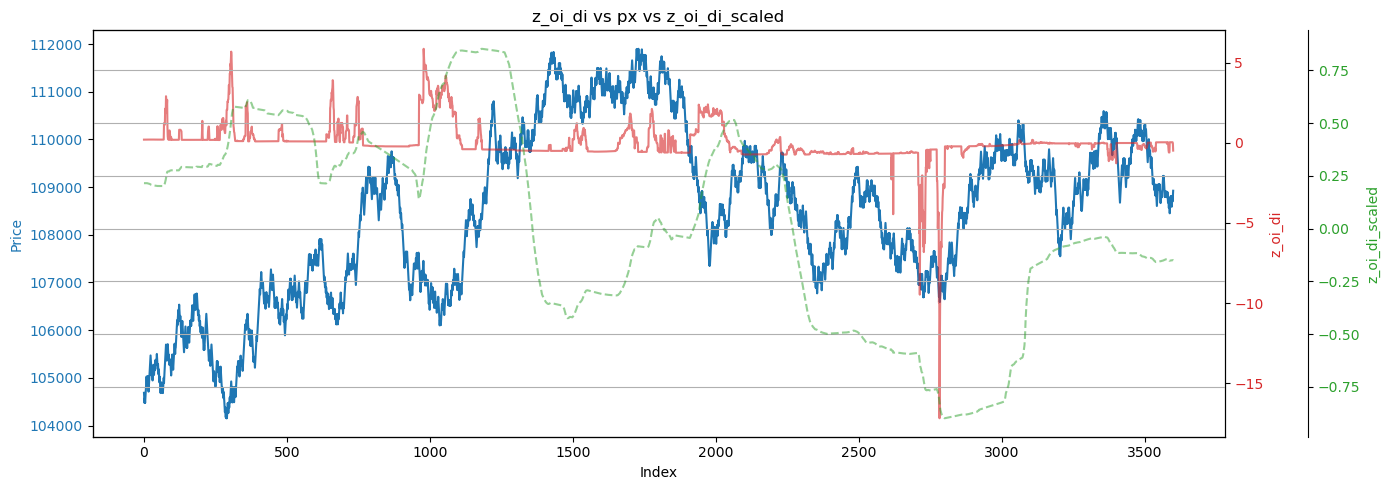

In [807]:
import polars as pl
import matplotlib.pyplot as plt

def plot_factor_price_target(
    df: pl.DataFrame,
    factor_name: str,
    price_col: str,
    target_col: str,
    n: int = 300
):
    df_plot = df.select([price_col, factor_name, target_col]).tail(n).to_pandas()

    fig, ax1 = plt.subplots(figsize=(14, 5))

    ax1.set_xlabel("Index")
    ax1.set_ylabel("Price", color="tab:blue")
    ax1.plot(df_plot[price_col], color="tab:blue", label="Price")
    ax1.tick_params(axis="y", labelcolor="tab:blue")

    ax2 = ax1.twinx()
    ax2.set_ylabel(factor_name, color="tab:red")
    ax2.plot(df_plot[factor_name], color="tab:red", alpha=0.6, label=factor_name)
    ax2.tick_params(axis="y", labelcolor="tab:red")

    ax3 = ax1.twinx()
    ax3.spines.right.set_position(("outward", 60))  # 第三个y轴往右偏移
    ax3.set_ylabel(target_col, color="tab:green")
    ax3.plot(df_plot[target_col], color="tab:green", alpha=0.5, linestyle="--", label=target_col)
    ax3.tick_params(axis="y", labelcolor="tab:green")

    plt.title(f"{factor_name} vs {price_col} vs {target_col}")
    fig.tight_layout()
    plt.grid(True)
    plt.show()

mo_df = rolling_mean_tanh_normalize(mo_df, 300)

mo_df = clean_df_drop_nulls(mo_df)

plot_factor_price_target(
    df=mo_df.with_columns([
        (pl.col("z_factor_impact_momentum") + pl.col("z_factor_oi_trend_slope")).rolling_mean(300).tanh()
        .alias("pread")
    ]),
    factor_name="z_oi_di",
    price_col="px",
    target_col="z_oi_di_scaled",  # 也可以改成别的 target，比如方向标签
    n=3600
)


In [711]:
import polars as pl
import pandas as pd

def time_split(
    df: pl.DataFrame,
    feature_cols: list[str],
    target_col: str,
    split_ratio: float = 0.8
):
    # 排序并去除缺失，保证 px 列也被保留
    df = df.sort('timestamp').drop_nulls(subset=feature_cols + [target_col, 'px']).to_pandas()

    n = df.shape[0]
    split_point = int(n * split_ratio)

    df_train = df.iloc[:split_point]
    df_test = df.iloc[split_point:]

    X_train = df_train[feature_cols]
    y_train = df_train[target_col]
    px_train = df_train['px']  # 价格训练集

    X_test = df_test[feature_cols]
    y_test = df_test[target_col]
    px_test = df_test['px']    # 价格测试集

    return X_train, y_train, px_train, X_test, y_test, px_test


In [713]:
exclude_prefixes = ['px', 'timestamp', 'timestamp_dt', 'symbol']
target_col = f"future_return_{avg_steps_1pct}"
# selected_factors

In [715]:
fct = ["z_factor_sentiment_net_scaled"]

In [717]:
X_train, y_train, px_train, X_test, y_test, px_test = time_split(mo_df, selected_factors, target_col)


In [719]:
from sklearn.mixture import GaussianMixture
import numpy as np
import pandas as pd # 假设y_train, y_test是pandas Series，为了示例

# 示例数据（模拟有正有负的收益率）
# np.random.seed(42)
# y_train = pd.Series(np.concatenate([np.random.randn(50)*0.005 + 0.015, np.random.randn(50)*0.005 - 0.01]))
# y_test = pd.Series(np.concatenate([np.random.randn(20)*0.006 + 0.02, np.random.randn(20)*0.006 - 0.005]))


y_train_np = y_train.to_numpy()
y_test_np = y_test.to_numpy()

gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(y_train_np.reshape(-1, 1))

# 获取 GMM 分量的均值
means = gmm.means_.flatten()

# 确定哪个 GMM 内部标签代表上涨（均值更大的那个）
upward_gmm_label = np.argmax(means)
downward_gmm_label = np.argmin(means) # 也可以明确找出下跌的标签

print("GMM 分量均值:", means)
print("均值较大的分量（上涨）对应的 GMM 内部原始标签:", upward_gmm_label)
print("均值较小的分量（下跌）对应的 GMM 内部原始标签:", downward_gmm_label)

# 训练集标签转换
train_labels_raw = gmm.predict(y_train_np.reshape(-1, 1))
y_train_binary = (train_labels_raw == upward_gmm_label).astype(int)

# 测试集标签转换 (使用训练集确定的映射关系)
test_labels_raw = gmm.predict(y_test_np.reshape(-1, 1))
y_test_binary = (test_labels_raw == upward_gmm_label).astype(int)

print("\n--- 验证最终的二元标签映射 ---")

# 检查原始 GMM 标签到最终二元标签的映射
# 假设 GMM 内部标签是 0 和 1
for gmm_raw_label in [0, 1]:
    # 找到这个原始标签对应的均值
    # 注意：这里需要确保 gmm_raw_label 是有效的索引
    if gmm_raw_label in [0, 1] and gmm_raw_label < len(means):
        corresponding_mean = means[gmm_raw_label]
        # 判断这个原始标签在最终的二元标签中会被映射成什么
        final_binary_value = 1 if gmm_raw_label == upward_gmm_label else 0
        print(f"GMM 内部标签 '{gmm_raw_label}' (均值: {corresponding_mean:.6f}) => 最终二元标签: {final_binary_value}")

print("\n--- 训练集最终二元标签示例 (前10个) ---")
print("原始收益率:", y_train_np[:10])
print("GMM原始标签:", train_labels_raw[:10])
print("最终二元标签:", y_train_binary[:10])

print("\n--- 测试集最终二元标签示例 (前10个) ---")
print("原始收益率:", y_test_np[:10])
print("GMM原始标签:", test_labels_raw[:10])
print("最终二元标签:", y_test_binary[:10])

GMM 分量均值: [ 0.00781562 -0.00458488]
均值较大的分量（上涨）对应的 GMM 内部原始标签: 0
均值较小的分量（下跌）对应的 GMM 内部原始标签: 1

--- 验证最终的二元标签映射 ---
GMM 内部标签 '0' (均值: 0.007816) => 最终二元标签: 1
GMM 内部标签 '1' (均值: -0.004585) => 最终二元标签: 0

--- 训练集最终二元标签示例 (前10个) ---
原始收益率: [0.00654698 0.00866942 0.00659127 0.00863397 0.00859737 0.00879169
 0.01084834 0.01086315 0.01086153 0.01329119]
GMM原始标签: [0 0 0 0 0 0 0 0 0 0]
最终二元标签: [1 1 1 1 1 1 1 1 1 1]

--- 测试集最终二元标签示例 (前10个) ---
原始收益率: [ 0.00470325  0.00266282  0.00271014  0.00272954  0.00062041 -0.00221432
 -0.00222358 -0.00478564 -0.00269558 -0.00057921]
GMM原始标签: [0 0 0 0 1 1 1 1 1 1]
最终二元标签: [1 1 1 1 0 0 0 0 0 0]


In [721]:
# === 3. Soft label 预测评估函数（与之前类似）===
def evaluate_soft_predictions(
    y_true_soft: np.ndarray,
    y_pred_soft: np.ndarray,
    model_name: str = "SoftLightGBM",
    lower_thresh: float = 0.3,
    upper_thresh: float = 0.7,
    print_report: bool = True
):
    # 硬标签：0.5 为界
    y_true = (y_true_soft >= 0.5).astype(int)
    base_pred = (y_pred_soft >= 0.5).astype(int)

    base_acc = accuracy_score(y_true, base_pred)
    base_auc = roc_auc_score(y_true, y_pred_soft)

    # 置信区间策略
    signals = np.full_like(y_pred_soft, -1, dtype=int)
    signals[y_pred_soft <= lower_thresh] = 0
    signals[y_pred_soft >= upper_thresh] = 1

    mask = signals != -1
    conf_acc = accuracy_score(y_true[mask], signals[mask]) if np.any(mask) else np.nan
    trading_rate = mask.mean()

    # 打包结果
    eval_dict = {
        'model': model_name,
        'base_acc': base_acc,
        'base_auc': base_auc,
        'conf_acc': conf_acc,
        'trading_rate': trading_rate,
        'conf_matrix': confusion_matrix(y_true[mask], signals[mask]) if np.any(mask) else None,
        'report': classification_report(y_true[mask], signals[mask], output_dict=True) if np.any(mask) else None
    }

    if print_report:
        print(f"\n=== 📊 {model_name} soft-label 评估 ===")
        print(f"🎯 ROC AUC: {base_auc:.4f}")
        print(f"✅ 全样本准确率: {base_acc:.4f}")
        print(f"📌 自信预测准确率: {conf_acc:.4f} (阈值 {lower_thresh}-{upper_thresh})")
        print(f"📈 出手率: {trading_rate:.2%}")

        if np.any(mask):
            print("\n🧮 混淆矩阵:")
            print(eval_dict['conf_matrix'])
            print("\n📝 分类报告:")
            print(classification_report(y_true[mask], signals[mask]))
        else:
            print("⚠️ 无 confident 区间预测样本")

    return eval_dict


GMM 均值: [ 0.00781562 -0.00458488]
上涨类的编号: 0
训练集中上涨的比例: 0.5090325647729974
测试集中上涨的比例: 0.4619771863117871
📈 Train Skew: -0.026483667674636894
📈 Test Skew: -0.07213261791310743
🔺 Train Kurtosis: 2.8546605164137304
🔺 Test Kurtosis: 2.7554995388781776


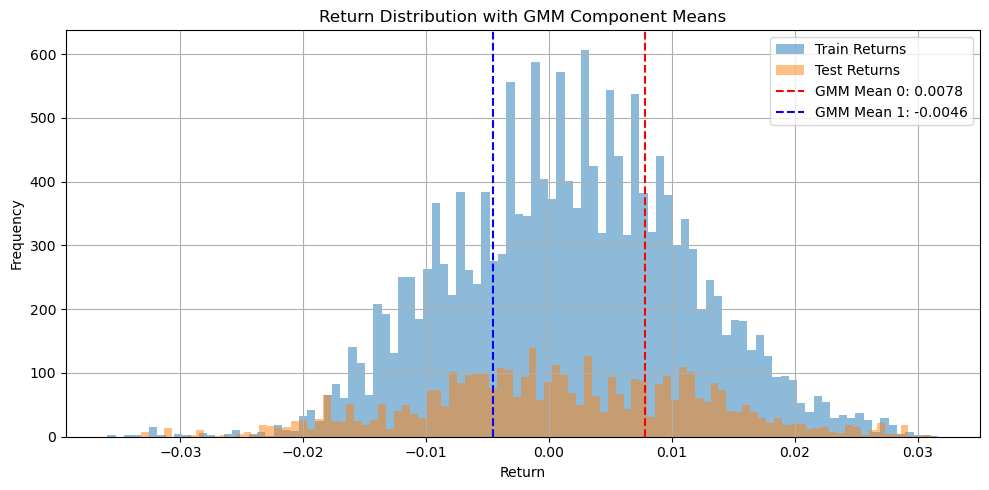

In [723]:
print("GMM 均值:", means)
print("上涨类的编号:", upward_gmm_label)
print("训练集中上涨的比例:", y_train_binary.mean())
print("测试集中上涨的比例:", y_test_binary.mean())

import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis

# 偏度：衡量分布的不对称性，0 = 对称；>0 = 右偏；<0 = 左偏
train_skew = skew(y_train_np)
test_skew = skew(y_test_np)

# 峰度：衡量尖峭程度，3 = 正态；>3 = 尖（肥尾）；<3 = 平
train_kurt = kurtosis(y_train_np, fisher=False)  # fisher=False 表示不减3，直接给出正态=3
test_kurt = kurtosis(y_test_np, fisher=False)

print("📈 Train Skew:", train_skew)
print("📈 Test Skew:", test_skew)
print("🔺 Train Kurtosis:", train_kurt)
print("🔺 Test Kurtosis:", test_kurt)

plt.figure(figsize=(10, 5))
plt.hist(y_train, bins=100, alpha=0.5, label='Train Returns')
plt.hist(y_test, bins=100, alpha=0.5, label='Test Returns')
plt.axvline(means[0], color='red', linestyle='--', label=f'GMM Mean 0: {means[0]:.4f}')
plt.axvline(means[1], color='blue', linestyle='--', label=f'GMM Mean 1: {means[1]:.4f}')
plt.title("Return Distribution with GMM Component Means")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [725]:
import matplotlib.pyplot as plt
import numpy as np

def plot_last_n_rows_with_px(y_test, y_test_binary, y_pred_prob, px, n=700):
    # 截取最后 n 行
    y_test_slice = y_test[-n:]
    y_test_binary_slice = y_test_binary[-n:]
    y_pred_prob_slice = y_pred_prob[-n:]
    px_slice = px[-n:]

    time_index = np.arange(len(y_test_slice))

    fig, ax1 = plt.subplots(figsize=(16, 7))

    # 原始收益
    ax1.plot(time_index, y_test_slice, label="Original Future Returns", color='gray', alpha=0.8)
    ax1.set_ylabel("Original Future Returns", color='gray')
    ax1.tick_params(axis='y', labelcolor='gray')

    # GMM 标签
    ax2 = ax1.twinx()
    ax2.scatter(time_index, y_test_binary_slice, label="GMM Labels", color='tab:blue', marker='o', s=20, alpha=0.7)
    ax2.set_ylabel("GMM Labels (0 or 1)", color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')
    ax2.set_ylim(-0.1, 1.1)

    # 模型预测概率
    ax3 = ax1.twinx()
    ax3.spines.right.set_position(("outward", 60))
    ax3.plot(time_index, y_pred_prob_slice, label="MODEL Predicted Probability", color='tab:green', alpha=0.4)
    ax3.set_ylabel("MODEL Predicted Probability", color='tab:green')
    ax3.tick_params(axis='y', labelcolor='tab:green')
    ax3.set_ylim(-0.05, 1.05)

    # 加价格线 (第4轴)
    ax4 = ax1.twinx()
    ax4.spines.right.set_position(("outward", 120))  # 再右移一层
    ax4.plot(time_index, px_slice, label="Price (px)", color='tab:red', linestyle='--', alpha=0.6)
    ax4.set_ylabel("Price (px)", color='tab:red')
    ax4.tick_params(axis='y', labelcolor='tab:red')

    # x轴
    ax1.set_xlabel("Time Index")
    plt.title(f"Compare Returns, Labels, Prediction & Price (Last {n} Rows)")

    # 图例
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    lines_3, labels_3 = ax3.get_legend_handles_labels()
    lines_4, labels_4 = ax4.get_legend_handles_labels()

    ax1.legend(
        lines_1 + lines_2 + lines_3 + lines_4,
        labels_1 + labels_2 + labels_3 + labels_4,
        loc='upper left'
    )

    plt.tight_layout()
    plt.show()


In [727]:
import lightgbm as lgb
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np


lgb_model = lgb.LGBMClassifier(n_estimators=1500, learning_rate=0.005, max_depth=7, verbose=-1)
lgb_model.fit(X_train, y_train_binary)

# 预测测试集
y_pred_prob = lgb_model.predict_proba(X_test)[:, 1]
y_pred_label = (y_pred_prob >= 0.5).astype(int)

# 评估测试集
print("Test Accuracy:", accuracy_score(y_test_binary, y_pred_label))
print(classification_report(y_test_binary, y_pred_label))
cm = confusion_matrix(y_test_binary, y_pred_label)
print("Confusion Matrix:")
print(cm)

Test Accuracy: 0.5411121673003803
              precision    recall  f1-score   support

           0       0.58      0.56      0.57      2264
           1       0.50      0.52      0.51      1944

    accuracy                           0.54      4208
   macro avg       0.54      0.54      0.54      4208
weighted avg       0.54      0.54      0.54      4208

Confusion Matrix:
[[1263 1001]
 [ 930 1014]]


In [729]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
y_pred_prob = lgb_model.predict_proba(X_test)[:, 1]
y_pred_label = (y_pred_prob >= 0.5).astype(int)

# 评估测试集
print("Test Accuracy:", accuracy_score(y_test_binary, y_pred_label))
print(classification_report(y_test_binary, y_pred_label))
cm = confusion_matrix(y_test_binary, y_pred_label)
print("Confusion Matrix:")
print(cm)
# 设置上下概率阈值
lower_thresh = 0.15
upper_thresh = 0.85

# 初始化标签为 -1（表示不出手）
y_pred_label = np.full_like(y_pred_prob, fill_value=-1, dtype=int)

# 预测为下跌（做空）
y_pred_label[y_pred_prob <= lower_thresh] = 0

# 预测为上涨（做多）
y_pred_label[y_pred_prob >= upper_thresh] = 1

# 筛选出模型明确给出方向的样本
mask = y_pred_label != -1

# 评估：只看模型明确判断的那部分（即“出手”的预测）
print("✅ Test Accuracy (Confident Predictions):", accuracy_score(y_test_binary[mask], y_pred_label[mask]))
print("📊 Classification Report (Confident Predictions):")
print(classification_report(y_test_binary[mask], y_pred_label[mask]))

print("🧮 Confusion Matrix (Confident Predictions):")
print(confusion_matrix(y_test_binary[mask], y_pred_label[mask]))

# 出手率（模型愿意下单的比例）
print("📈 Trading Rate (Confident Predictions):", mask.mean())


Test Accuracy: 0.5411121673003803
              precision    recall  f1-score   support

           0       0.58      0.56      0.57      2264
           1       0.50      0.52      0.51      1944

    accuracy                           0.54      4208
   macro avg       0.54      0.54      0.54      4208
weighted avg       0.54      0.54      0.54      4208

Confusion Matrix:
[[1263 1001]
 [ 930 1014]]
✅ Test Accuracy (Confident Predictions): 0.570873786407767
📊 Classification Report (Confident Predictions):
              precision    recall  f1-score   support

           0       0.54      0.63      0.58       244
           1       0.61      0.52      0.56       271

    accuracy                           0.57       515
   macro avg       0.57      0.57      0.57       515
weighted avg       0.58      0.57      0.57       515

🧮 Confusion Matrix (Confident Predictions):
[[153  91]
 [130 141]]
📈 Trading Rate (Confident Predictions): 0.12238593155893536


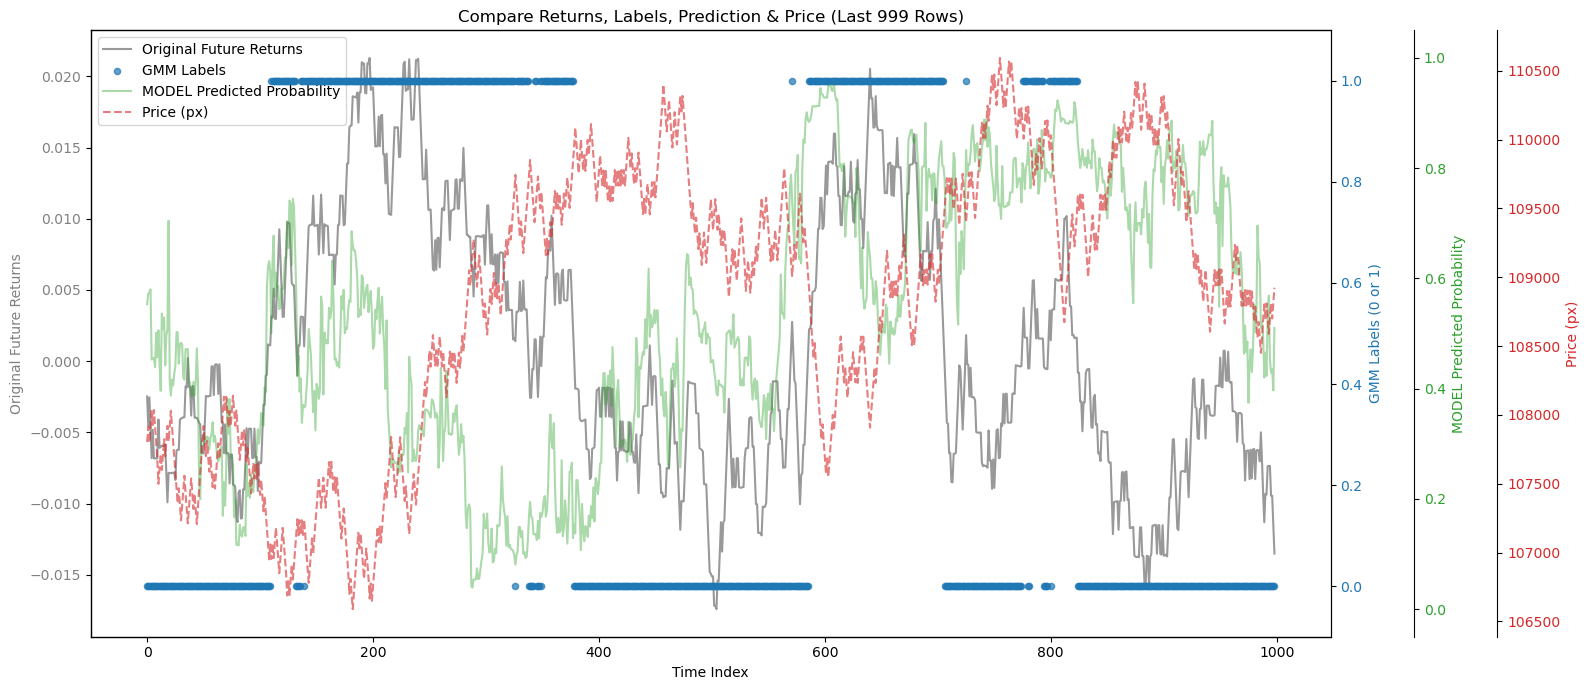

In [731]:
plot_last_n_rows_with_px(y_test, y_test_binary, y_pred_prob, px_test, n=999)

y_train_prob = lgb_model.predict_proba(X_train)[:, 1]


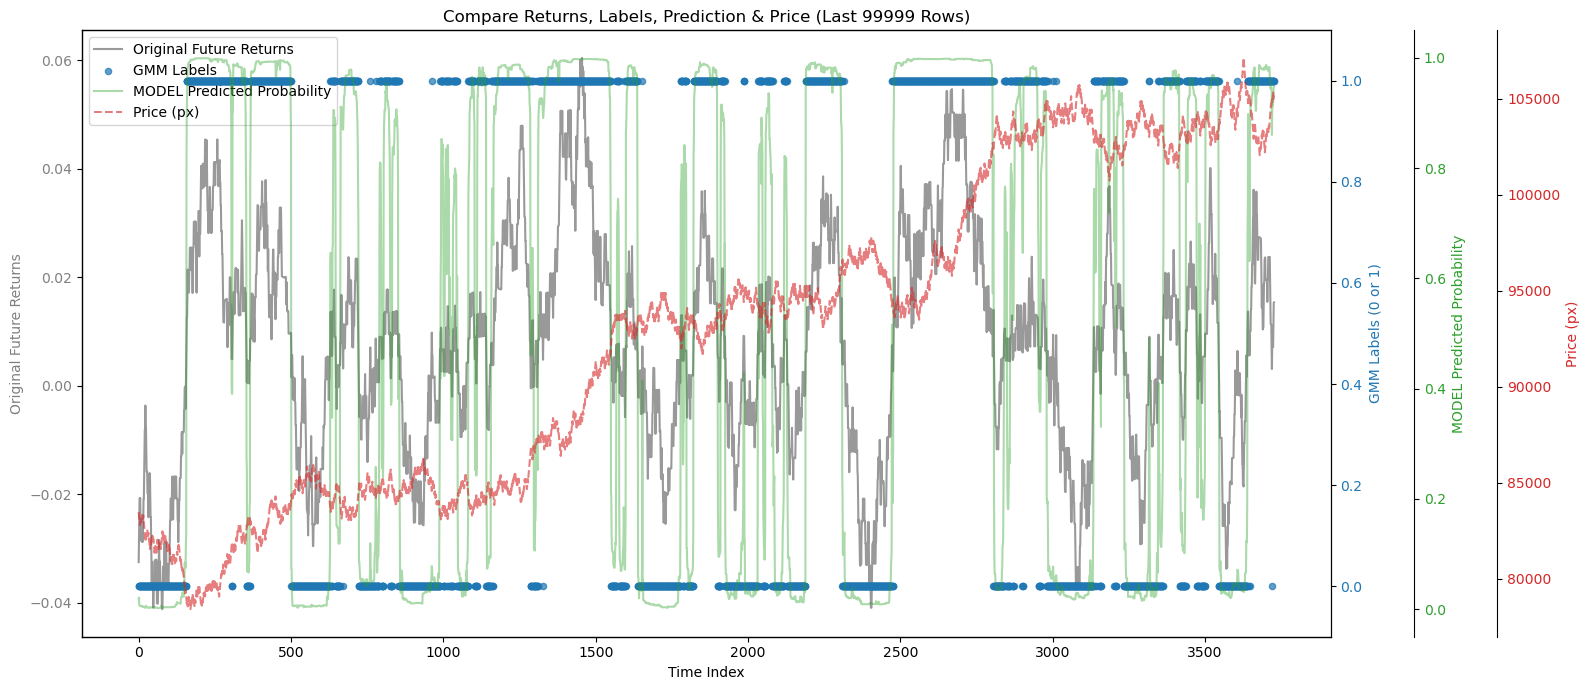

In [561]:
plot_last_n_rows_with_px(y_train, y_train_binary, y_train_prob, px_train, n=99999)


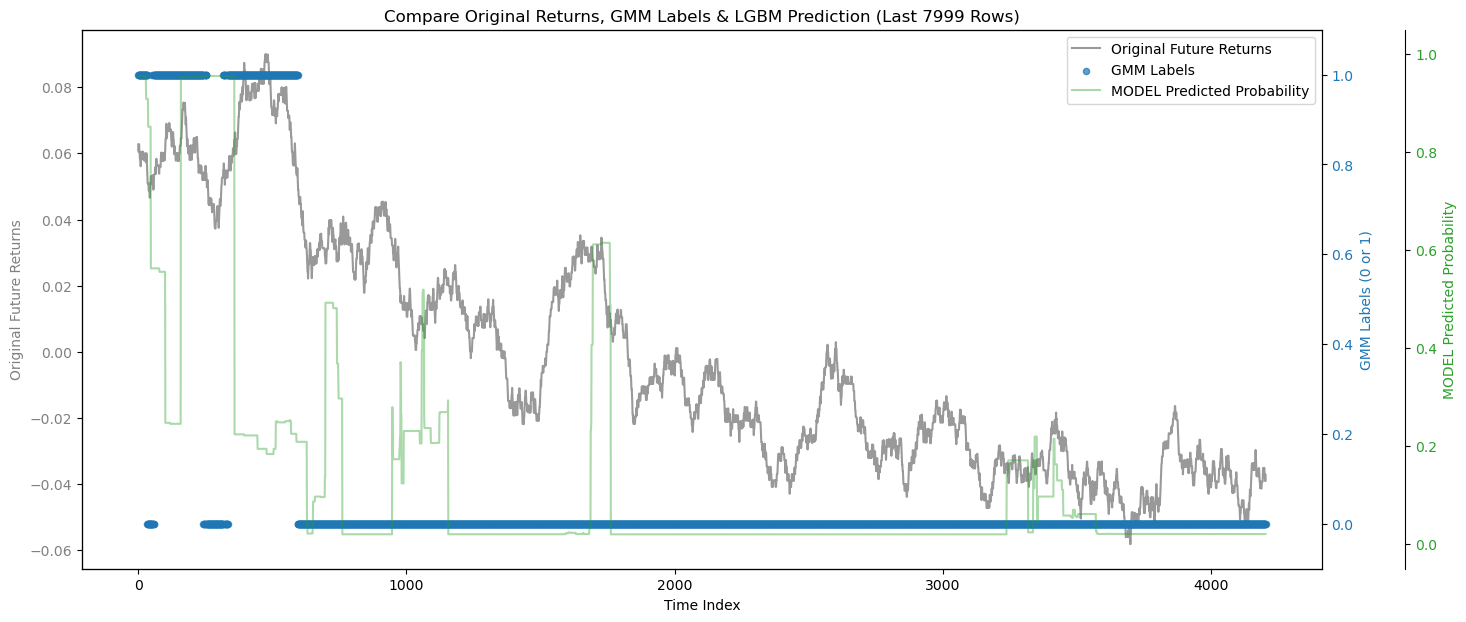

In [168]:
plot_last_n_rows(y_test, y_test_binary, y_pred_prob, n=7999)

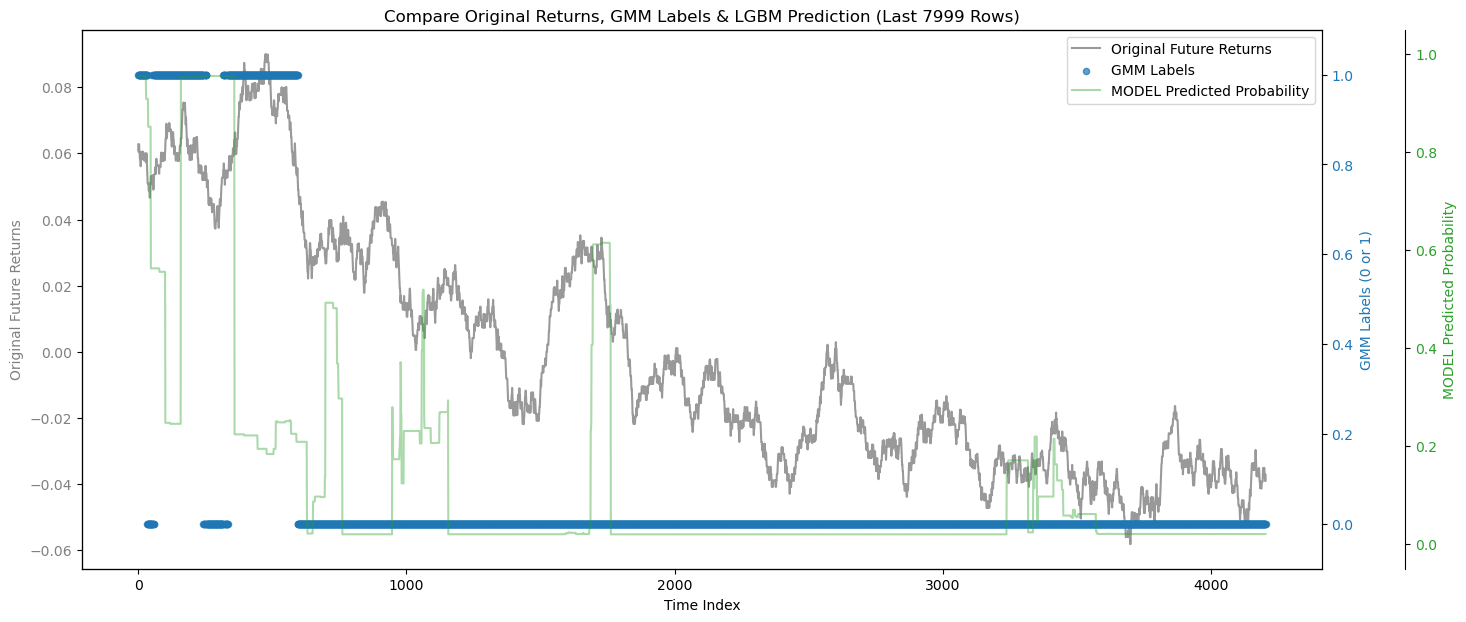

In [170]:
plot_last_n_rows(y_test, y_test_binary, y_pred_prob, n=7999)

In [22]:
# import shap

# explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(X_train)

# shap.summary_plot(shap_values, X_train, plot_type="dot")  # 全体概览

In [23]:
# shap.dependence_plot("z_oi_down_divergence_scaled", shap_values, X_train)  # 局部分析


In [24]:
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

cat_model = CatBoostClassifier(iterations=4000, learning_rate=0.005, depth=7, verbose=0)
cat_model.fit(X_train, y_train_binary)

# 预测
y_pred_prob = cat_model.predict_proba(X_test)[:, 1]
y_pred_label = (y_pred_prob >= 0.5).astype(int)

# 评估
print("CatBoost Test Accuracy:", accuracy_score(y_test_binary, y_pred_label))
print(classification_report(y_test_binary, y_pred_label))
cm = confusion_matrix(y_test_binary, y_pred_label)
print("Confusion Matrix:")
print(cm)

CatBoost Test Accuracy: 0.6009389671361502
              precision    recall  f1-score   support

           0       0.74      0.73      0.73      1605
           1       0.21      0.22      0.21       525

    accuracy                           0.60      2130
   macro avg       0.47      0.47      0.47      2130
weighted avg       0.61      0.60      0.60      2130

Confusion Matrix:
[[1164  441]
 [ 409  116]]


In [25]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
# 预测
y_pred_prob = cat_model.predict_proba(X_test)[:, 1]
y_pred_label = (y_pred_prob >= 0.5).astype(int)

# 评估
print("CatBoost Test Accuracy:", accuracy_score(y_test_binary, y_pred_label))
print(classification_report(y_test_binary, y_pred_label))
cm = confusion_matrix(y_test_binary, y_pred_label)
print("Confusion Matrix:")
print(cm)
# 设置上下概率阈值
lower_thresh = 0.15
upper_thresh = 0.85

# 初始化标签为 -1（表示不出手）
y_pred_label = np.full_like(y_pred_prob, fill_value=-1, dtype=int)

# 预测为下跌（做空）
y_pred_label[y_pred_prob <= lower_thresh] = 0

# 预测为上涨（做多）
y_pred_label[y_pred_prob >= upper_thresh] = 1

# 筛选出模型明确给出方向的样本
mask = y_pred_label != -1

# 评估：只看模型明确判断的那部分（即“出手”的预测）
print("✅ CatBoost Test Accuracy (Confident Predictions):", accuracy_score(y_test_binary[mask], y_pred_label[mask]))
print("📊 Classification Report (Confident Predictions):")
print(classification_report(y_test_binary[mask], y_pred_label[mask]))

print("🧮 Confusion Matrix (Confident Predictions):")
print(confusion_matrix(y_test_binary[mask], y_pred_label[mask]))

# 出手率（模型愿意下单的比例）
print("📈 Trading Rate (Confident Predictions):", mask.mean())


CatBoost Test Accuracy: 0.6009389671361502
              precision    recall  f1-score   support

           0       0.74      0.73      0.73      1605
           1       0.21      0.22      0.21       525

    accuracy                           0.60      2130
   macro avg       0.47      0.47      0.47      2130
weighted avg       0.61      0.60      0.60      2130

Confusion Matrix:
[[1164  441]
 [ 409  116]]
✅ CatBoost Test Accuracy (Confident Predictions): 0.7701149425287356
📊 Classification Report (Confident Predictions):
              precision    recall  f1-score   support

           0       0.87      0.87      0.87        76
           1       0.09      0.09      0.09        11

    accuracy                           0.77        87
   macro avg       0.48      0.48      0.48        87
weighted avg       0.77      0.77      0.77        87

🧮 Confusion Matrix (Confident Predictions):
[[66 10]
 [10  1]]
📈 Trading Rate (Confident Predictions): 0.04084507042253521


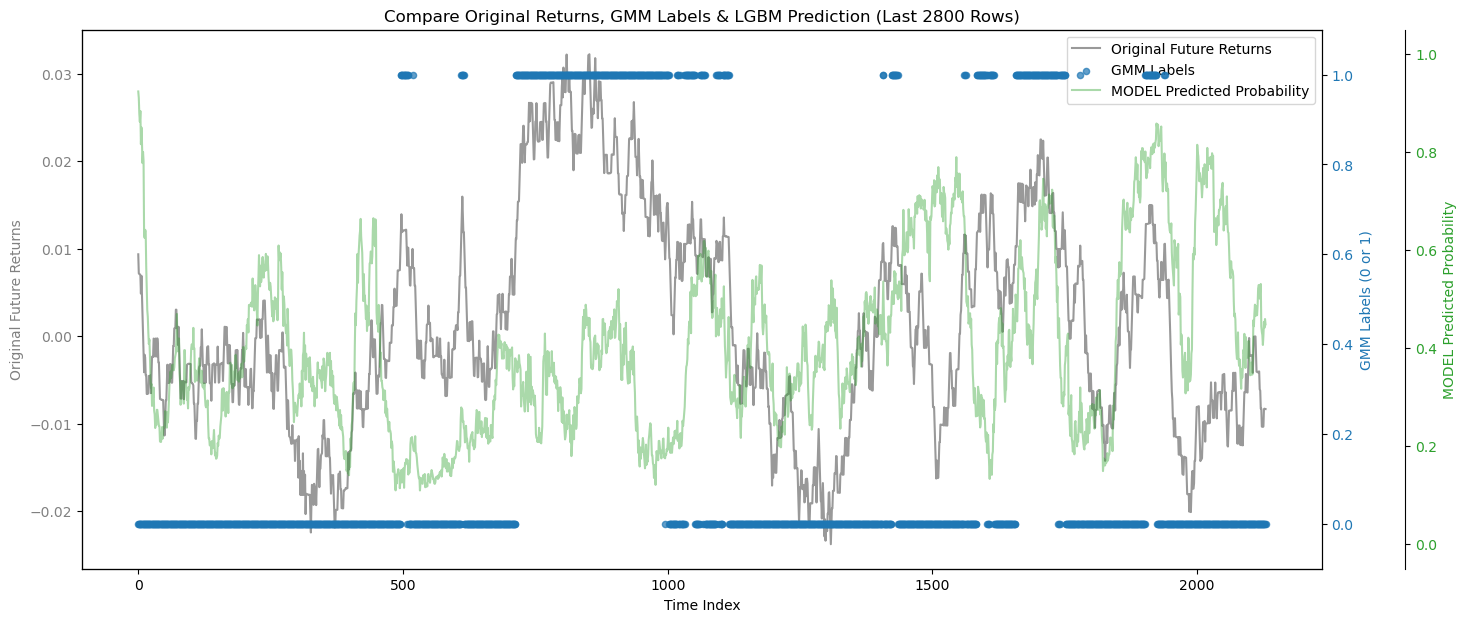

In [26]:
plot_last_n_rows(y_test, y_test_binary, y_pred_prob, n=2800)


In [27]:
# import matplotlib.pyplot as plt
# import shap
# from sklearn.metrics import roc_curve, auc, RocCurveDisplay

# # 1. ROC 曲线（推荐自定义绘图）
# y_score = model.predict_proba(X_test)[:, 1]
# fpr, tpr, thresholds = roc_curve(y_test_binary, y_score)
# roc_auc = auc(fpr, tpr)

# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
# plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic Curve')
# plt.legend(loc="lower right")
# plt.grid(True)
# plt.show()

# # 如果你想也画一下 sklearn 内置版本
# # RocCurveDisplay.from_estimator(model, X_test, y_test)  # 可选

# # 2. SHAP 值解释
# explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(X_test)
# shap.summary_plot(shap_values, X_test)


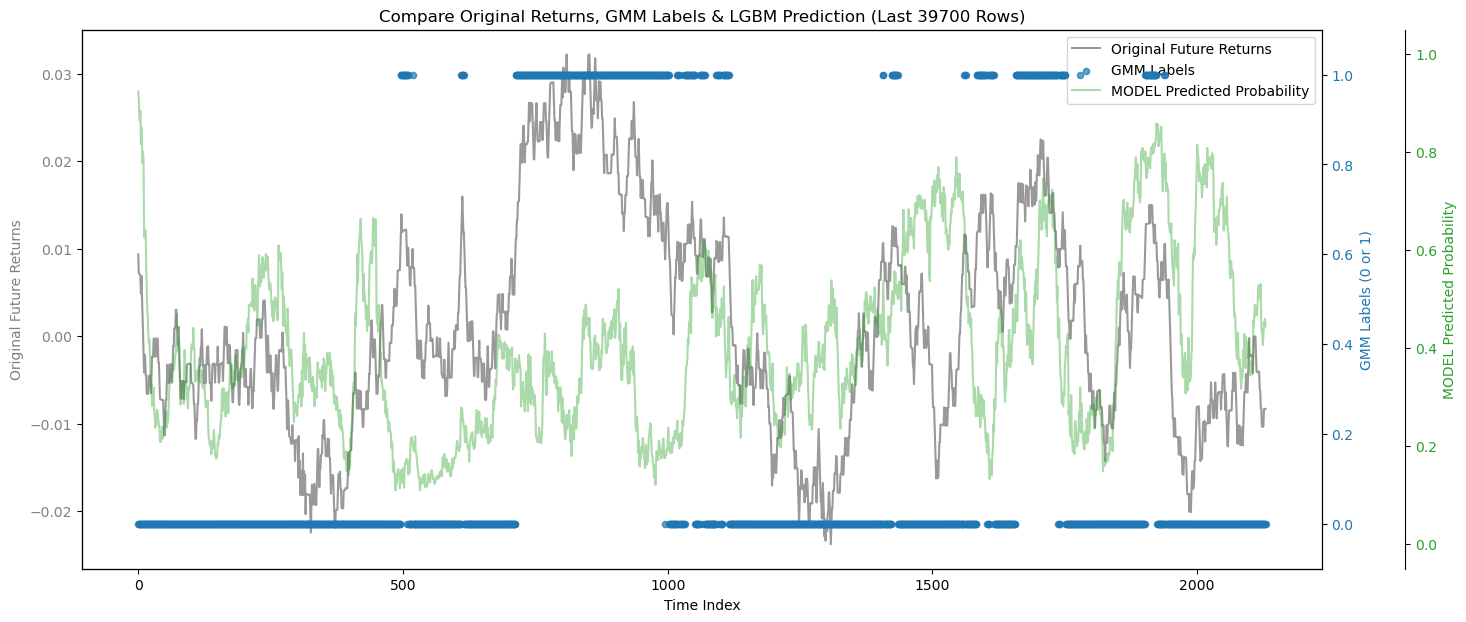

In [28]:
plot_last_n_rows(y_test, y_test_binary, y_pred_prob, n=39700)


In [29]:
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

xgb_model = xgb.XGBClassifier(n_estimators=5000, learning_rate=0.005, max_depth=7, verbosity=0, use_label_encoder=False)
xgb_model.fit(X_train, y_train_binary)

# 预测
y_pred_prob = xgb_model.predict_proba(X_test)[:, 1]
y_pred_label = (y_pred_prob >= 0.5).astype(int)

# 评估
print("XGBoost Test Accuracy:", accuracy_score(y_test_binary, y_pred_label))
print(classification_report(y_test_binary, y_pred_label))
m = confusion_matrix(y_test_binary, y_pred_label)
print("Confusion Matrix:")
print(cm)

XGBoost Test Accuracy: 0.7708920187793428
              precision    recall  f1-score   support

           0       0.82      0.89      0.85      1605
           1       0.55      0.41      0.47       525

    accuracy                           0.77      2130
   macro avg       0.68      0.65      0.66      2130
weighted avg       0.75      0.77      0.76      2130

Confusion Matrix:
[[1164  441]
 [ 409  116]]


In [30]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
y_pred_prob = xgb_model.predict_proba(X_test)[:, 1]
y_pred_label = (y_pred_prob >= 0.5).astype(int)

# 评估
print("XGBoost Test Accuracy:", accuracy_score(y_test_binary, y_pred_label))
print(classification_report(y_test_binary, y_pred_label))
m = confusion_matrix(y_test_binary, y_pred_label)
print("Confusion Matrix:")
print(cm)
# 设置上下概率阈值
lower_thresh = 0.2
upper_thresh = 0.8

# 初始化标签为 -1（表示不出手）
y_pred_label = np.full_like(y_pred_prob, fill_value=-1, dtype=int)

# 预测为下跌（做空）
y_pred_label[y_pred_prob <= lower_thresh] = 0

# 预测为上涨（做多）
y_pred_label[y_pred_prob >= upper_thresh] = 1

# 筛选出模型明确给出方向的样本
mask = y_pred_label != -1

# 评估：只看模型明确判断的那部分（即“出手”的预测）
print("✅ CatBoost Test Accuracy (Confident Predictions):", accuracy_score(y_test_binary[mask], y_pred_label[mask]))
print("📊 Classification Report (Confident Predictions):")
print(classification_report(y_test_binary[mask], y_pred_label[mask]))

print("🧮 Confusion Matrix (Confident Predictions):")
print(confusion_matrix(y_test_binary[mask], y_pred_label[mask]))

# 出手率（模型愿意下单的比例）
print("📈 Trading Rate (Confident Predictions):", mask.mean())


XGBoost Test Accuracy: 0.7708920187793428
              precision    recall  f1-score   support

           0       0.82      0.89      0.85      1605
           1       0.55      0.41      0.47       525

    accuracy                           0.77      2130
   macro avg       0.68      0.65      0.66      2130
weighted avg       0.75      0.77      0.76      2130

Confusion Matrix:
[[1164  441]
 [ 409  116]]
✅ CatBoost Test Accuracy (Confident Predictions): 0.8111888111888111
📊 Classification Report (Confident Predictions):
              precision    recall  f1-score   support

           0       0.82      0.96      0.88       868
           1       0.72      0.36      0.48       276

    accuracy                           0.81      1144
   macro avg       0.77      0.66      0.68      1144
weighted avg       0.80      0.81      0.79      1144

🧮 Confusion Matrix (Confident Predictions):
[[830  38]
 [178  98]]
📈 Trading Rate (Confident Predictions): 0.5370892018779343


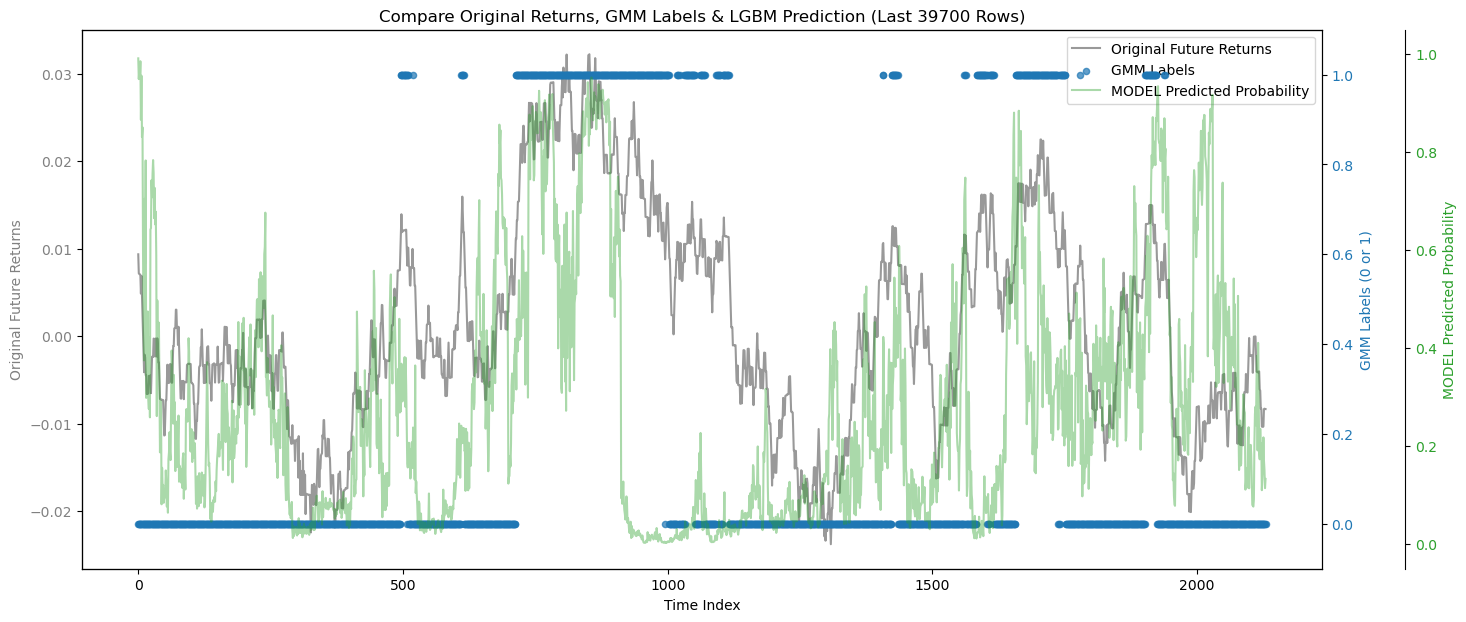

In [31]:
plot_last_n_rows(y_test, y_test_binary, y_pred_prob, n=39700)


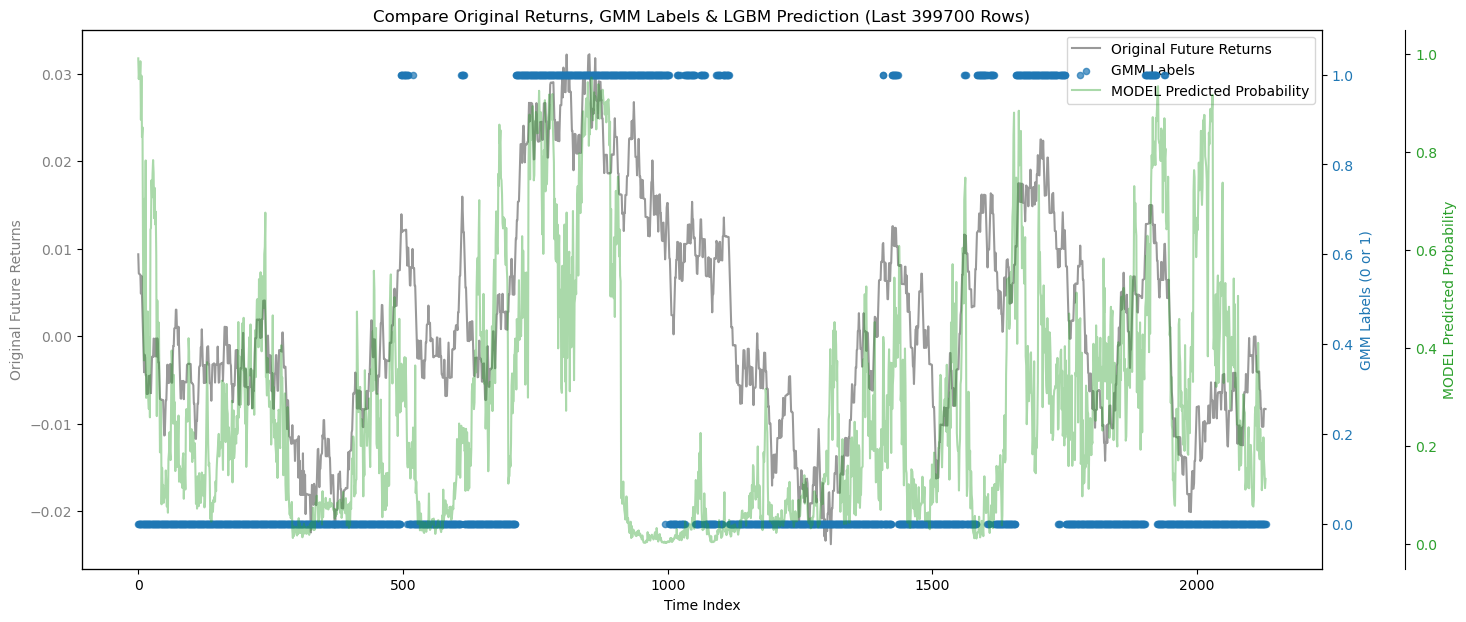

In [32]:
plot_last_n_rows(y_test, y_test_binary, y_pred_prob, n=399700)


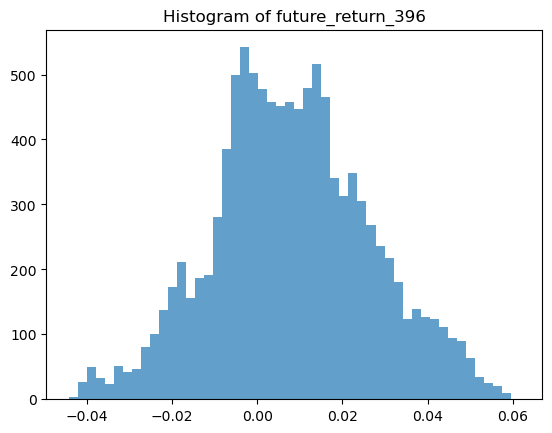

Skewness: 0.0871, Kurtosis: -0.1508
Shapiro-Wilk Test: stat=0.9909, p-value=0.0000
拒绝正态分布假设，数据可能不是正态分布


In [33]:
import polars as pl
import matplotlib.pyplot as plt
from scipy.stats import shapiro

# 读数据


# 1. 画直方图（先导出为numpy）
plt.hist(mo_df[target_col].to_numpy(), bins=50, alpha=0.7)
plt.title(f"Histogram of {target_col}")
plt.show()

# 2. 计算偏度和峰度
skewness = mo_df.select(pl.col(target_col).skew()).item()
kurtosis = mo_df.select(pl.col(target_col).kurtosis()).item()
print(f"Skewness: {skewness:.4f}, Kurtosis: {kurtosis:.4f}")

# 3. Shapiro-Wilk 检验 (样本不要太大，建议 <5000)
sample = mo_df[target_col].to_numpy()[:5000]
stat, p_value = shapiro(sample)
print(f"Shapiro-Wilk Test: stat={stat:.4f}, p-value={p_value:.4f}")

if p_value > 0.05:
    print("无法拒绝正态分布假设，数据可能近似正态分布")
else:
    print("拒绝正态分布假设，数据可能不是正态分布")


In [34]:
def train_evaluate_lgb(X_train, y_train, X_test, y_test):
    model = lgb.LGBMClassifier(n_estimators=1000, learning_rate=0.05, max_depth=7, verbose=-1)
    model.fit(X_train, y_train)
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    y_pred_label = (y_pred_prob >= 0.5).astype(int)
    print("LightGBM Test Accuracy:", accuracy_score(y_test, y_pred_label))
    print(classification_report(y_test, y_pred_label))
    return y_pred_prob

def train_evaluate_xgb(X_train, y_train, X_test, y_test):
    model = xgb.XGBClassifier(n_estimators=1000, learning_rate=0.05, max_depth=7, eval_metric='logloss')
    model.fit(X_train, y_train)
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    y_pred_label = (y_pred_prob >= 0.5).astype(int)
    print("XGBoost Test Accuracy:", accuracy_score(y_test, y_pred_label))
    print(classification_report(y_test, y_pred_label))
    return y_pred_prob

def train_evaluate_catboost(X_train, y_train, X_test, y_test):
    model = CatBoostClassifier(iterations=1000, learning_rate=0.05, depth=7, verbose=False)
    model.fit(X_train, y_train)
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    y_pred_label = (y_pred_prob >= 0.5).astype(int)
    print("CatBoost Test Accuracy:", accuracy_score(y_test, y_pred_label))
    print(classification_report(y_test, y_pred_label))
    return y_pred_prob


In [35]:
def plot_model_comparison(y_test, y_test_binary, preds_dict, n=700):
    """
    preds_dict: dict, key=模型名, value=对应的预测概率数组
    """
    y_test_slice = y_test[-n:]
    y_test_binary_slice = y_test_binary[-n:]
    time_index = np.arange(len(y_test_slice))

    fig, ax1 = plt.subplots(figsize=(16, 7))

    # 原始收益
    ax1.plot(time_index, y_test_slice, label="Original Future Returns", color='gray', alpha=0.8)
    ax1.set_ylabel("Original Future Returns", color='gray')
    ax1.tick_params(axis='y', labelcolor='gray')

    # GMM标签
    ax2 = ax1.twinx()
    ax2.scatter(time_index, y_test_binary_slice, label="GMM Labels", color='tab:blue', marker='o', s=20, alpha=0.7)
    ax2.set_ylabel("GMM Labels (0 or 1)", color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')
    ax2.set_ylim(-0.1, 1.1)

    # 多模型预测概率，右侧y轴，颜色自动分配
    ax3 = ax1.twinx()
    ax3.spines.right.set_position(("outward", 60))
    colors = ['tab:green', 'tab:red', 'tab:orange', 'tab:purple']
    
    for i, (model_name, pred_prob) in enumerate(preds_dict.items()):
        pred_prob_slice = pred_prob[-n:]
        ax3.plot(time_index, pred_prob_slice, label=f"{model_name} Predicted Probability", color=colors[i % len(colors)], alpha=0.1)
    
    ax3.set_ylabel("Predicted Probability", color='black')
    ax3.tick_params(axis='y', labelcolor='black')
    ax3.set_ylim(-0.05, 1.05)

    ax1.set_xlabel("Time Index")
    plt.title(f"Compare Original Returns, GMM Labels & Model Predictions (Last {n} Rows)")

    # 合并图例
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    lines_3, labels_3 = ax3.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2 + lines_3, labels_1 + labels_2 + labels_3, loc='best')

    plt.show()


In [36]:
y_pred_prob_lgb = train_evaluate_lgb(X_train, y_train_binary, X_test, y_test_binary)
y_pred_prob_xgb = train_evaluate_xgb(X_train, y_train_binary, X_test, y_test_binary)
y_pred_prob_cat = train_evaluate_catboost(X_train, y_train_binary, X_test, y_test_binary)

preds_dict = {
    'LightGBM': y_pred_prob_lgb,
    'XGBoost': y_pred_prob_xgb,
    'CatBoost': y_pred_prob_cat,
}


LightGBM Test Accuracy: 0.6272300469483568
              precision    recall  f1-score   support

           0       0.77      0.72      0.74      1605
           1       0.29      0.35      0.32       525

    accuracy                           0.63      2130
   macro avg       0.53      0.54      0.53      2130
weighted avg       0.65      0.63      0.64      2130

XGBoost Test Accuracy: 0.7492957746478873
              precision    recall  f1-score   support

           0       0.81      0.88      0.84      1605
           1       0.49      0.36      0.41       525

    accuracy                           0.75      2130
   macro avg       0.65      0.62      0.63      2130
weighted avg       0.73      0.75      0.74      2130

CatBoost Test Accuracy: 0.5408450704225352
              precision    recall  f1-score   support

           0       0.81      0.51      0.62      1605
           1       0.30      0.64      0.41       525

    accuracy                           0.54      2130


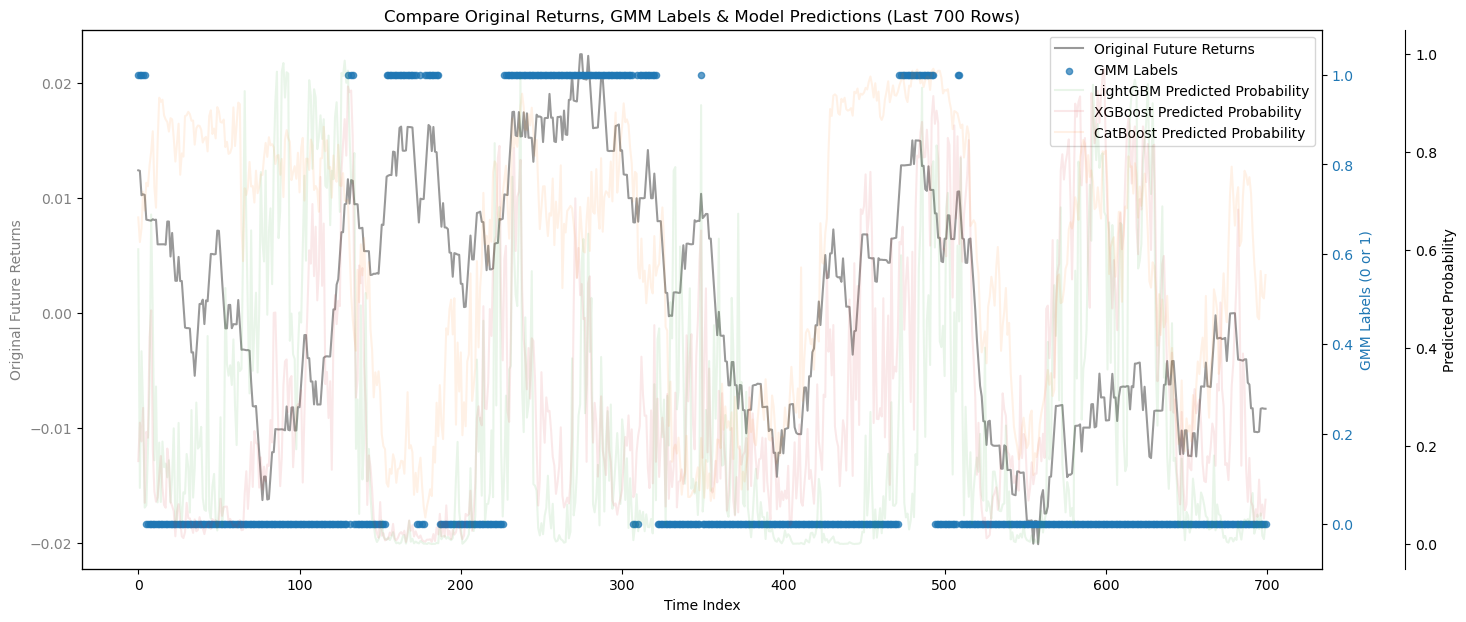

In [37]:
plot_model_comparison(y_test, y_test_binary, preds_dict, n=700)

In [38]:
import pandas as pd
from scipy.stats import spearmanr, pearsonr

# 创建 DataFrame，只保留模型出手的样本
df_result = pd.DataFrame({
    'true_return': y_test[mask],          # 真实收益
    'predicted': y_pred_label[mask],      # 预测标签（0 或 1）
    'pred_prob': y_pred_prob[mask]        # 概率（可选，用于排序或分组）
})

# 排序指标可以选用 pred_prob（推荐），而不是 0/1 的 predicted
df_result['rank'] = df_result['pred_prob'].rank(ascending=False)

# 分组看 top 10%、top 20% 的平均真实收益
top_10 = df_result[df_result['rank'] <= len(df_result) * 0.1]
top_20 = df_result[df_result['rank'] <= len(df_result) * 0.2]

print(f"Top 10% 平均真实收益: {top_10['true_return'].mean():.6f}")
print(f"Top 20% 平均真实收益: {top_20['true_return'].mean():.6f}")

# 信息系数（IC）：建议用 pred_prob 作为连续变量
ic = pearsonr(df_result['pred_prob'], df_result['true_return'])[0]
rank_ic = spearmanr(df_result['pred_prob'], df_result['true_return'])[0]

print(f"📉 Pearson IC: {ic:.4f}")
print(f"📉 Rank IC（秩相关）: {rank_ic:.4f}")
long_returns = df_result[df_result['predicted'] == 1]['true_return']
short_returns = -df_result[df_result['predicted'] == 0]['true_return']  # 做空收益是 -return

print(f"📈 多头平均收益: {long_returns.mean():.6f}")
print(f"📉 空头平均收益: {short_returns.mean():.6f}")
print(f"💰 多空平均收益: {(long_returns.mean() + short_returns.mean()):.6f}")
print("✅ 多头胜率:", (long_returns > 0).mean())
print("✅ 空头胜率:", (short_returns > 0).mean())


Top 10% 平均真实收益: 0.018522
Top 20% 平均真实收益: 0.010028
📉 Pearson IC: 0.4635
📉 Rank IC（秩相关）: 0.0541
📈 多头平均收益: 0.017872
📉 空头平均收益: 0.001793
💰 多空平均收益: 0.019664
✅ 多头胜率: 0.9044117647058824
✅ 空头胜率: 0.6081349206349206


In [39]:
import torch
print(torch.cuda.is_available())  # True 表示可以用GPU，False 表示没装GPU版本或没驱动
print(torch.__version__)

True
2.5.1


C:\Users\Grayman\AppData\Local\Temp\ipykernel_49108\3044644876.py:23: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


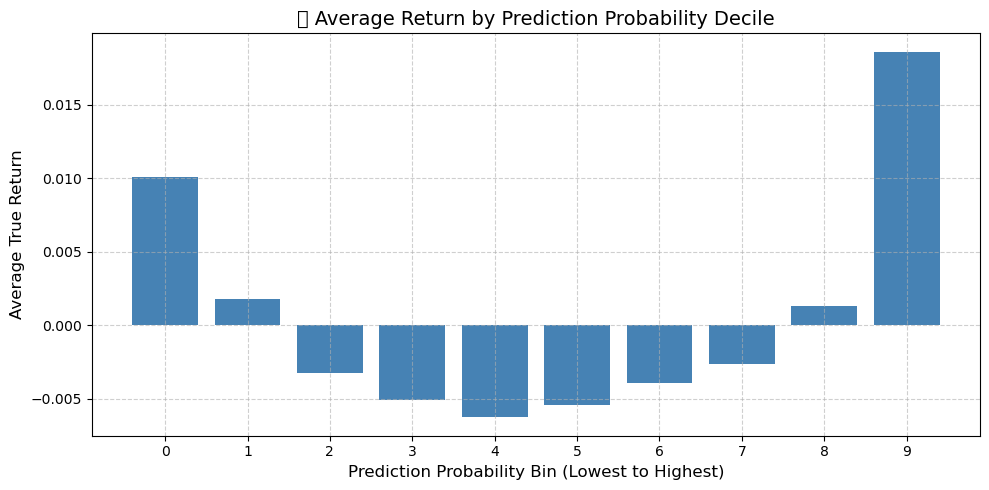

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_result has columns: true_return, pred_prob
df_result['bin'] = pd.qcut(df_result['pred_prob'], q=10, labels=False)

# Group by bin and calculate statistics
bin_stats = df_result.groupby('bin').agg(
    mean_return=('true_return', 'mean'),
    std_return=('true_return', 'std'),
    win_rate=('true_return', lambda x: (x > 0).mean()),
    count=('true_return', 'count')
).reset_index()

# Plot average return by bin
plt.figure(figsize=(10, 5))
plt.bar(bin_stats['bin'], bin_stats['mean_return'], color='steelblue')
plt.title("📊 Average Return by Prediction Probability Decile", fontsize=14)
plt.xlabel("Prediction Probability Bin (Lowest to Highest)", fontsize=12)
plt.ylabel("Average True Return", fontsize=12)
plt.xticks(bin_stats['bin'])
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [280]:
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.preprocessing import LabelEncoder
import torch

# Label Encode y（如果是0/1就不用）
y_train_enc = y_train_binary.astype(int)
y_test_enc = y_test_binary.astype(int)

# TabNet 训练
tabnet = TabNetClassifier(
    n_d=8,
    n_a=8,
    n_steps=5,
    device_name='cuda' if torch.cuda.is_available() else 'cpu',
    verbose=1,
)
tabnet.fit(
    X_train=X_train.values, y_train=y_train_enc,
    eval_set=[(X_test.values, y_test_enc)],
    eval_metric=['accuracy'],
    max_epochs=200,
    patience=10,
    batch_size=1024,
    virtual_batch_size=128
)

# 预测概率
y_pred_prob_tabnet = tabnet.predict_proba(X_test.values)[:, 1]


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.69196 | val_0_accuracy: 0.52487 |  0:00:57s
epoch 1  | loss: 0.68917 | val_0_accuracy: 0.52487 |  0:01:55s



KeyboardInterrupt



In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
# TabNet 预测概率（这部分你已经写好了）
y_pred_prob_tabnet = tabnet.predict_proba(X_test.values)[:, 1]
# 设置上下概率阈值
lower_thresh = 0.2
upper_thresh = 0.8

# 初始化标签为 -1（表示不出手）
y_pred_label = np.full_like(y_pred_prob_tabnet, fill_value=-1, dtype=int)

# 预测为下跌（做空）
y_pred_label[y_pred_prob_tabnet <= lower_thresh] = 0

# 预测为上涨（做多）
y_pred_label[y_pred_prob_tabnet >= upper_thresh] = 1

# 筛选出模型明确给出方向的样本
mask = y_pred_label != -1

# 评估：只看模型明确判断的那部分（即“出手”的预测）
print("✅ TabNet Test Accuracy (Confident Predictions):", accuracy_score(y_test_binary[mask], y_pred_label[mask]))
print("📊 Classification Report (Confident Predictions):")
print(classification_report(y_test_binary[mask], y_pred_label[mask]))

print("🧮 Confusion Matrix (Confident Predictions):")
print(confusion_matrix(y_test_binary[mask], y_pred_label[mask]))

# 出手率（模型愿意下单的比例）
print("📈 Trading Rate (Confident Predictions):", mask.mean())


In [ ]:
def plot_with_trade_signals(y_test, y_test_binary, y_pred_prob, n=700, lower_thresh=0.15, upper_thresh=0.85):
    y_test_slice = y_test[-n:]
    y_test_binary_slice = y_test_binary[-n:]
    y_pred_prob_slice = y_pred_prob[-n:]
    
    time_index = np.arange(len(y_test_slice))
    
    # 策略信号
    long_signals = y_pred_prob_slice >= upper_thresh
    short_signals = y_pred_prob_slice <= lower_thresh

    fig, ax = plt.subplots(figsize=(16, 7))

    ax.plot(time_index, y_test_slice, label="Future Returns", color='gray', alpha=0.7)
    ax.scatter(time_index[long_signals], y_test_slice[long_signals], color='green', label='📈 Long Signal', marker='^', s=100)
    ax.scatter(time_index[short_signals], y_test_slice[short_signals], color='red', label='📉 Short Signal', marker='v', s=100)

    ax.set_title(f"Trading Signals on Future Returns (Last {n} rows)")
    ax.set_xlabel("Time Index")
    ax.set_ylabel("Future Return")
    ax.legend()
    ax.grid(True)
    plt.show()


In [ ]:
plot_with_trade_signals(
    y_test=y_test, 
    y_test_binary=y_test_binary, 
    y_pred_prob=y_pred_prob_tabnet, 
    n=99700, 
    lower_thresh=0.2, 
    upper_thresh=0.8
)


In [ ]:
def plot_bar_classification(y_test_binary, y_pred_label, n=700):
    y_test_slice = y_test_binary[-n:]
    y_pred_slice = y_pred_label[-n:]
    
    time_index = np.arange(len(y_test_slice))

    fig, ax = plt.subplots(figsize=(16, 4))
    width = 0.4

    ax.bar(time_index - width/2, y_test_slice, width=width, label="True Label", alpha=0.7)
    ax.bar(time_index + width/2, y_pred_slice, width=width, label="Predicted Label", alpha=0.7)

    ax.set_ylim(-0.1, 1.1)
    ax.set_title(f"True vs Predicted Labels (Last {n} rows)")
    ax.set_xlabel("Time Index")
    ax.legend()
    ax.grid(True)
    plt.show()


In [ ]:
import seaborn as sns

def plot_prediction_confidence(y_pred_prob):
    plt.figure(figsize=(10, 5))
    sns.histplot(y_pred_prob, bins=50, kde=True, color='skyblue')
    plt.title("Distribution of Model Predicted Probabilities")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Count")
    plt.axvline(0.15, color='red', linestyle='--', label='Short Threshold')
    plt.axvline(0.85, color='green', linestyle='--', label='Long Threshold')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
def plot_cumulative_returns(y_test, y_pred_prob, lower_thresh=0.15, upper_thresh=0.85):
    y_pred_label = np.full_like(y_pred_prob, -1)
    y_pred_label[y_pred_prob >= upper_thresh] = 1
    y_pred_label[y_pred_prob <= lower_thresh] = -1

    # 策略收益 = 预测方向 × 实际收益
    strat_returns = y_pred_label * y_test
    strat_returns[y_pred_label == -1] = 0  # 不出手为0收益

    cum_returns_strategy = np.cumsum(strat_returns)
    cum_returns_buyhold = np.cumsum(y_test)

    plt.figure(figsize=(16, 6))
    plt.plot(cum_returns_strategy, label='📈 Strategy Return', color='orange')
    plt.plot(cum_returns_buyhold, label='💹 Buy & Hold Return', color='gray')
    plt.title("Cumulative Returns: Strategy vs Buy & Hold")
    plt.xlabel("Time Index")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
import numpy as np

# 设置阈值
lower_thresh = 0.15
upper_thresh = 0.85

# 生成 TabNet 标签
y_pred_label_tabnet = np.full_like(y_pred_prob_tabnet, -1, dtype=int)
y_pred_label_tabnet[y_pred_prob_tabnet >= upper_thresh] = 1
y_pred_label_tabnet[y_pred_prob_tabnet <= lower_thresh] = 0

plot_bar_classification(
    y_test_binary=y_test_binary,
    y_pred_label=y_pred_label_tabnet,
    n=700
)


In [ ]:
plot_prediction_confidence(y_pred_prob_tabnet)


In [ ]:
plot_cumulative_returns(y_test, y_pred_prob_tabnet, lower_thresh=0.2, upper_thresh=0.8)


In [ ]:
plot_last_n_rows_with_px(y_test, y_test_binary, y_pred_prob_tabnet, px_test, n=999999)

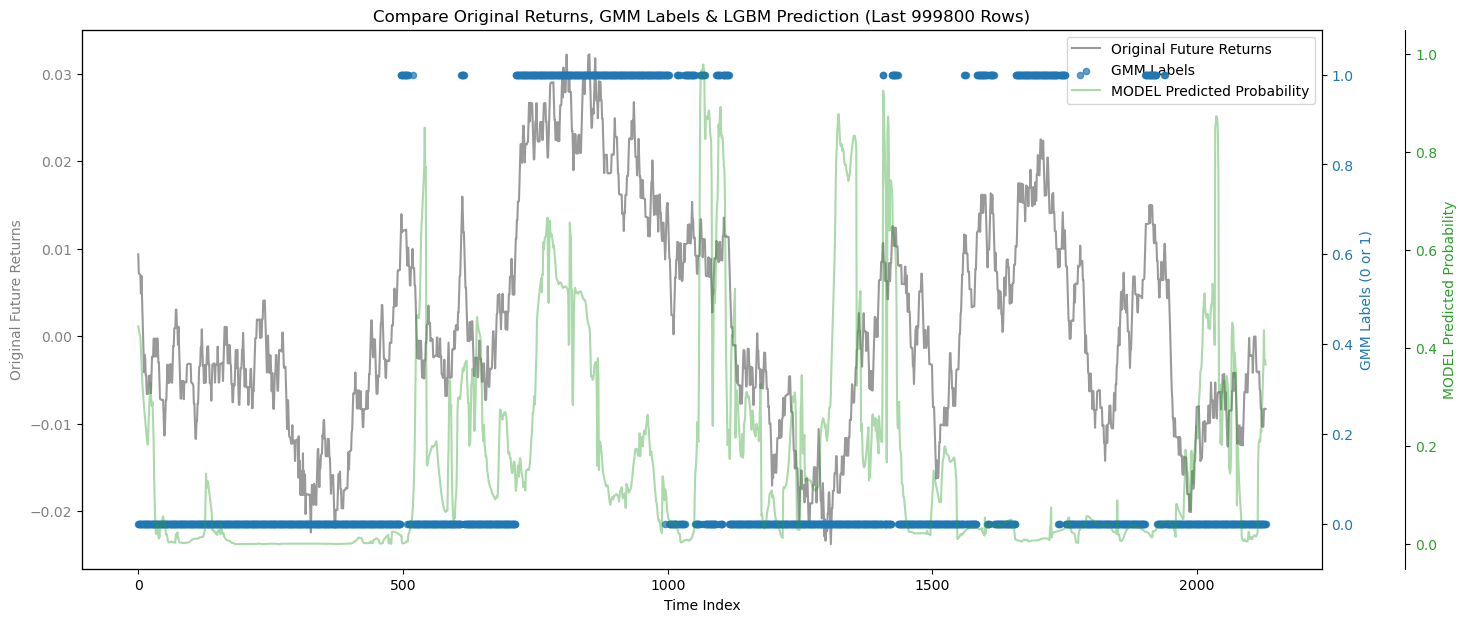

In [51]:
plot_last_n_rows(y_test, y_test_binary, y_pred_prob_tabnet, n=999800)


In [52]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

def plot_tabnet_feature_importance(tabnet_model, feature_names):
    imp_df = pd.Series(tabnet_model.feature_importances_, index=feature_names).sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=imp_df.values, y=imp_df.index, color="skyblue")
    plt.title("TabNet Feature Importance")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.grid(True)
    plt.show()


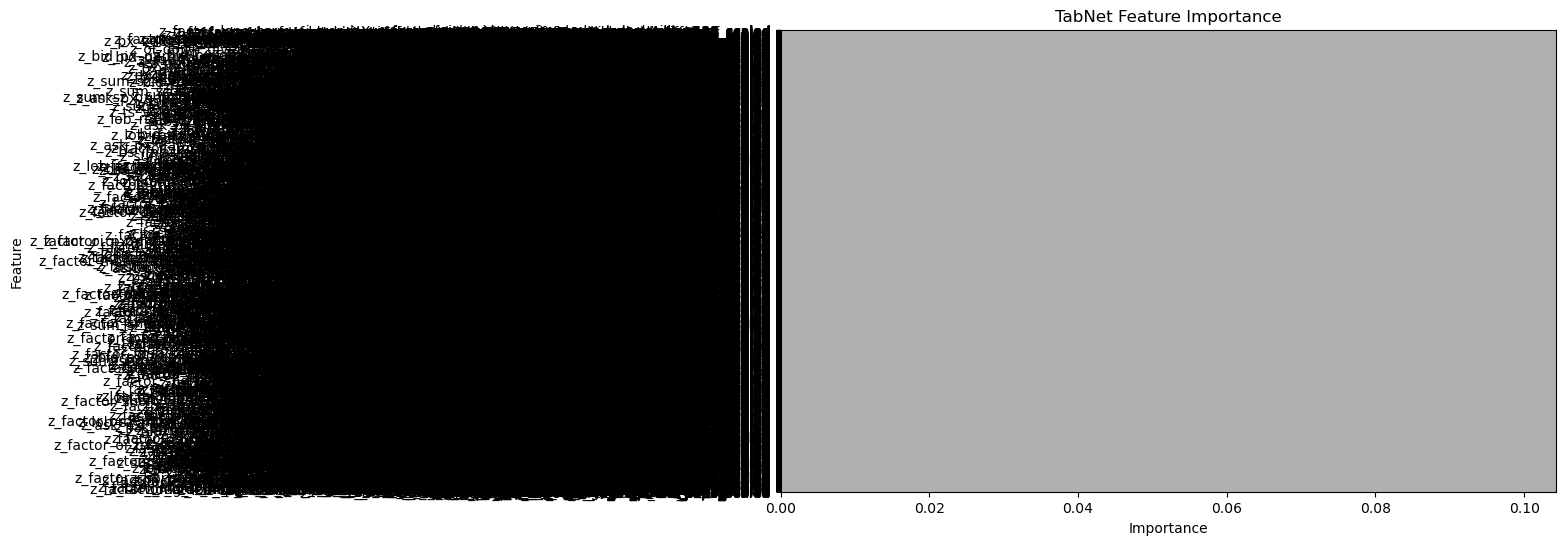

In [53]:
plot_tabnet_feature_importance(tabnet, X_train.columns)


In [54]:
# 用于阈值分箱
y_pred_label = np.full_like(y_pred_prob_tabnet, fill_value=-1, dtype=int)
y_pred_label[y_pred_prob_tabnet <= 0.15] = 0
y_pred_label[y_pred_prob_tabnet >= 0.85] = 1
mask = y_pred_label != -1
print("TabNet Confident Accuracy:", accuracy_score(y_test_binary[mask], y_pred_label[mask]))


TabNet Confident Accuracy: 0.7736535662299855


y_test_binary length: 2130
y_pred_prob_tabnet length: 2130
mask length: 2130
y_true_confident length: 1374
y_pred_confident length: 1374


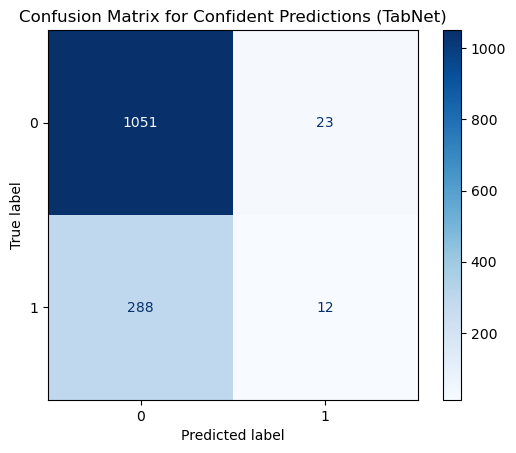

In [55]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print(f"y_test_binary length: {len(y_test_binary)}")
print(f"y_pred_prob_tabnet length: {len(y_pred_prob_tabnet)}")

# 生成分箱标签
y_pred_label = np.full_like(y_pred_prob_tabnet, fill_value=-1, dtype=int)
y_pred_label[y_pred_prob_tabnet <= 0.15] = 0
y_pred_label[y_pred_prob_tabnet >= 0.85] = 1
mask = y_pred_label != -1

print(f"mask length: {len(mask)}")  # 应该和 y_pred_label 一致

# 使用mask筛选后，长度应该相同
y_true_confident = y_test_binary[mask]
y_pred_confident = y_pred_label[mask]

print(f"y_true_confident length: {len(y_true_confident)}")
print(f"y_pred_confident length: {len(y_pred_confident)}")

# 计算混淆矩阵并绘图
cm = confusion_matrix(y_true_confident, y_pred_confident)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Confident Predictions (TabNet)")
plt.show()


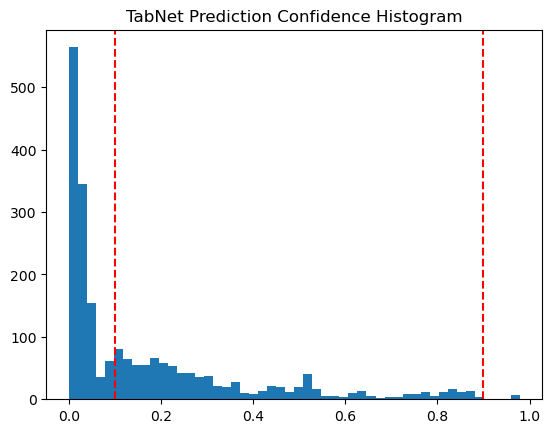

In [56]:
import matplotlib.pyplot as plt

plt.hist(y_pred_prob_tabnet, bins=50)
plt.axvline(0.1, color='red', linestyle='--')
plt.axvline(0.9, color='red', linestyle='--')
plt.title("TabNet Prediction Confidence Histogram")
plt.show()


In [57]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# 模拟数据
# X_train: (N_samples, N_features)
# y_train_binary: (N_samples,)
# X_test, y_test_binary 同理

def create_sequences(X, y, time_steps=100):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i+time_steps])
        ys.append(y[i+time_steps])  # 标签对应下一个时间步
    return np.array(Xs), np.array(ys)


# 先创建时间序列数据
X_train_seq, y_train_seq = create_sequences(X_train, y_train_binary, time_steps=200)
X_test_seq, y_test_seq = create_sequences(X_test, y_test_binary, time_steps=200)

# 转成TensorDataset
train_dataset = TensorDataset(torch.tensor(X_train_seq, dtype=torch.float32),
                              torch.tensor(y_train_seq, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# 定义模型
class GRUClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1, num_layers=2, bidirectional=False):
        super().__init__()
        self.bidirectional = bidirectional
        self.gru = nn.GRU(
            input_dim, hidden_dim, num_layers,
            batch_first=True, dropout=0.3,
            bidirectional=bidirectional
        )
        factor = 2 if bidirectional else 1
        self.layer_norm = nn.LayerNorm(hidden_dim * factor)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim * factor, output_dim)

    def forward(self, x):
        out, _ = self.gru(x)  # out shape: (B, T, H)
        out = out[:, -1, :]   # 取最后时间步，shape: (B, H*factor)
        out = self.layer_norm(out)
        out = self.dropout(out)
        out = torch.sigmoid(self.fc(out)).squeeze()
        return out



model = GRUClassifier(input_dim=X_train_seq.shape[2], hidden_dim=64).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 训练
model.train()
for epoch in range(50):
    epoch_loss = 0
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * x_batch.size(0)
    epoch_loss /= len(train_dataset)
    print(f"Epoch {epoch}, Loss: {epoch_loss:.4f}")

# 测试预测
model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test_seq, dtype=torch.float32).to(device)
    y_pred_prob = model(X_test_tensor).cpu().numpy()



Using device: cuda
Epoch 0, Loss: 0.2016
Epoch 1, Loss: 0.1207
Epoch 2, Loss: 0.1104
Epoch 3, Loss: 0.1074
Epoch 4, Loss: 0.1055
Epoch 5, Loss: 0.1002
Epoch 6, Loss: 0.0961
Epoch 7, Loss: 0.0958
Epoch 8, Loss: 0.0910
Epoch 9, Loss: 0.0906
Epoch 10, Loss: 0.0884
Epoch 11, Loss: 0.0861
Epoch 12, Loss: 0.0847
Epoch 13, Loss: 0.0839
Epoch 14, Loss: 0.0823
Epoch 15, Loss: 0.0775
Epoch 16, Loss: 0.0846
Epoch 17, Loss: 0.0837
Epoch 18, Loss: 0.0761
Epoch 19, Loss: 0.0834
Epoch 20, Loss: 0.0789
Epoch 21, Loss: 0.0787
Epoch 22, Loss: 0.0781
Epoch 23, Loss: 0.0739
Epoch 24, Loss: 0.0801
Epoch 25, Loss: 0.0747
Epoch 26, Loss: 0.0732
Epoch 27, Loss: 0.0737
Epoch 28, Loss: 0.0712
Epoch 29, Loss: 0.0746
Epoch 30, Loss: 0.0741
Epoch 31, Loss: 0.0730
Epoch 32, Loss: 0.0706
Epoch 33, Loss: 0.0745
Epoch 34, Loss: 0.0747
Epoch 35, Loss: 0.0736
Epoch 36, Loss: 0.0743
Epoch 37, Loss: 0.0708
Epoch 38, Loss: 0.0743
Epoch 39, Loss: 0.0747
Epoch 40, Loss: 0.0720
Epoch 41, Loss: 0.0697
Epoch 42, Loss: 0.0691
Ep

In [58]:
# 普通评估（概率）
print("=== Evaluation on test set ===")
print(f"Predicted probabilities (first 10): {y_pred_prob[:10]}")

# 阈值分类预测，阈值默认0.5
y_pred_label = (y_pred_prob >= 0.5).astype(int)

print(f"Accuracy: {accuracy_score(y_test_seq, y_pred_label):.4f}")
print("Classification Report:")
print(classification_report(y_test_seq, y_pred_label))



=== Evaluation on test set ===
Predicted probabilities (first 10): [0.29842642 0.27588576 0.24543121 0.20725623 0.17010097 0.13863885
 0.13088857 0.12953216 0.13046363 0.12912494]
Accuracy: 0.6254
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.60      0.70      1405
           1       0.39      0.70      0.51       525

    accuracy                           0.63      1930
   macro avg       0.62      0.65      0.60      1930
weighted avg       0.72      0.63      0.65      1930



In [59]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 假设 y_pred_prob_gru 是GRU模型预测的概率，y_test_seq是测试集真实标签
print("X_test_seq shape:", X_test_seq.shape)
print("y_test_seq shape:", y_test_seq.shape)
print("y_pred_prob shape:", y_pred_prob.shape)

lower_thresh = 0.1
upper_thresh = 0.9

y_pred_label = np.full_like(y_pred_prob, -1, dtype=int)
y_pred_label[y_pred_prob <= lower_thresh] = 0
y_pred_label[y_pred_prob >= upper_thresh] = 1
mask = y_pred_label != -1

print("Accuracy:", accuracy_score(y_test_seq[mask], y_pred_label[mask]))
print(classification_report(y_test_seq[mask], y_pred_label[mask]))
print(confusion_matrix(y_test_seq[mask], y_pred_label[mask]))
print("Trading Rate:", mask.mean())



X_test_seq shape: (1930, 200, 3073)
y_test_seq shape: (1930,)
y_pred_prob shape: (1930,)
Accuracy: 0.6087662337662337
              precision    recall  f1-score   support

           0       0.81      0.57      0.67       862
           1       0.41      0.69      0.51       370

    accuracy                           0.61      1232
   macro avg       0.61      0.63      0.59      1232
weighted avg       0.69      0.61      0.62      1232

[[495 367]
 [115 255]]
Trading Rate: 0.6383419689119171


In [60]:
import matplotlib.pyplot as plt
import numpy as np

def plot_gru_predictions(y_test_continuous, y_test_seq, y_pred_prob, y_pred_label, n=700,
                         lower_thresh=0.1, upper_thresh=0.9):
    """
    y_test_continuous: 原始连续收益或其他连续变量，长度和y_test_seq一致
    y_test_seq: 真实二分类标签（0或1）
    y_pred_prob: 模型预测概率（0~1之间）
    y_pred_label: 基于阈值生成的预测标签，可能含-1表示不出手
    n: 最后n个时间点
    """
    # 取最后 n 行数据切片
    y_test_cont_slice = y_test_continuous[-n:]
    y_test_seq_slice = y_test_seq[-n:]
    y_pred_prob_slice = y_pred_prob[-n:]
    y_pred_label_slice = y_pred_label[-n:]
    
    time_index = np.arange(len(y_test_seq_slice))  # 0 到 n-1
    
    fig, ax1 = plt.subplots(figsize=(16, 7))

    # 左侧y轴：原始连续收益曲线
    ax1.plot(time_index, y_test_cont_slice, label="Original Continuous Returns", color='gray', alpha=0.8)
    ax1.set_ylabel("Original Continuous Returns", color='gray')
    ax1.tick_params(axis='y', labelcolor='gray')

    # 右侧第1个y轴：真实二分类标签，散点图
    ax2 = ax1.twinx()
    ax2.scatter(time_index, y_test_seq_slice, label="True Labels", color='tab:blue', marker='o', s=20, alpha=0.7)
    ax2.set_ylabel("True Labels (0 or 1)", color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')
    ax2.set_ylim(-0.1, 1.1)

    # 右侧第2个y轴，右偏移：预测概率曲线
    ax3 = ax1.twinx()
    ax3.spines.right.set_position(("outward", 60))
    ax3.plot(time_index, y_pred_prob_slice, label="Predicted Probability", color='tab:green', alpha=0.5)
    ax3.set_ylabel("Predicted Probability", color='tab:green')
    ax3.tick_params(axis='y', labelcolor='tab:green')
    ax3.set_ylim(-0.05, 1.05)

    # 标出阈值上下界，方便观察
    ax3.axhline(y=lower_thresh, color='red', linestyle='--', alpha=0.6, label=f"Lower Threshold = {lower_thresh}")
    ax3.axhline(y=upper_thresh, color='red', linestyle='--', alpha=0.6, label=f"Upper Threshold = {upper_thresh}")

    # 右侧第3个y轴，右偏移更多：预测标签（0/1/-1）散点图，-1用灰色标注为“不出手”
    ax4 = ax1.twinx()
    ax4.spines.right.set_position(("outward", 120))
    # 标记不同的预测标签
    colors = {1: 'green', 0: 'red', -1: 'gray'}
    markers = {1: 'o', 0: 'x', -1: '.'}
    for label_val in np.unique(y_pred_label_slice):
        mask = (y_pred_label_slice == label_val)
        ax4.scatter(time_index[mask], y_pred_label_slice[mask], 
                    label=f"Predicted Label = {label_val}", 
                    color=colors[label_val], marker=markers[label_val], s=30, alpha=0.6)
    ax4.set_ylabel("Predicted Label (-1=No Trade)", color='purple')
    ax4.tick_params(axis='y', labelcolor='purple')
    ax4.set_ylim(-1.1, 1.1)

    # x轴和标题
    ax1.set_xlabel("Time Index")
    plt.title(f"GRU Prediction vs True Labels & Original Returns (Last {n} points)")

    # 合并图例
    lines = []
    labels = []
    for ax in [ax1, ax2, ax3, ax4]:
        line, label = ax.get_legend_handles_labels()
        lines.extend(line)
        labels.extend(label)
    ax1.legend(lines, labels, loc='upper left')

    plt.show()



KeyboardInterrupt



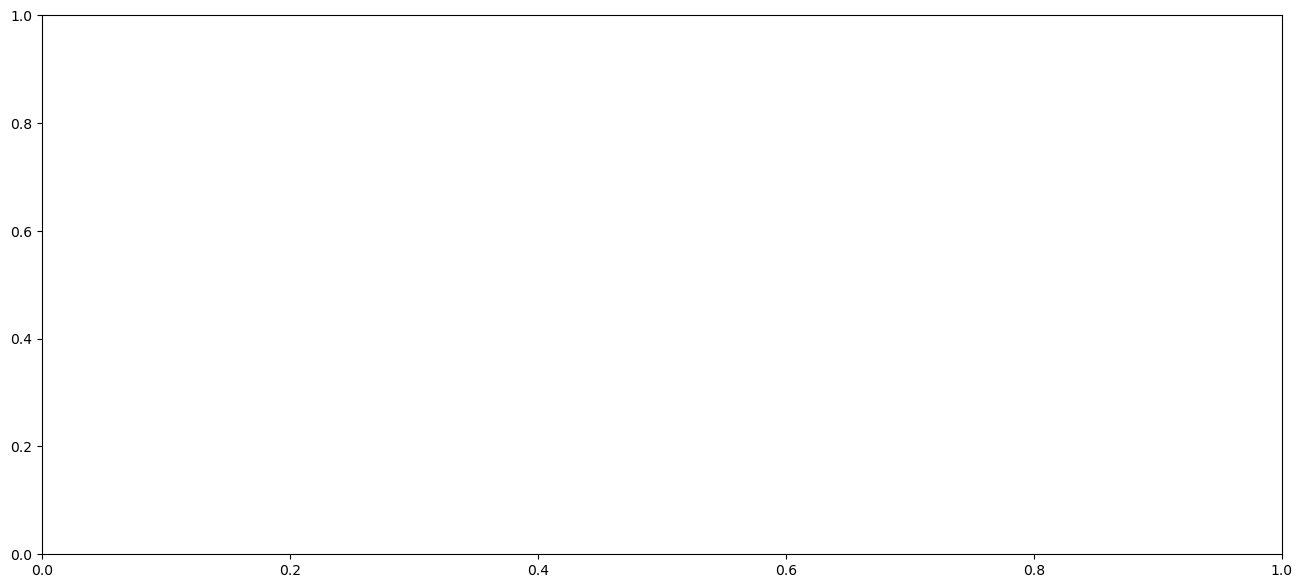

In [61]:
# 如果你有原始测试集连续收益，比如 price_test 或 returns_test
# y_test_continuous = returns_test[-len(y_test_seq):]

# 如果没有，可以用 y_test_seq 本身代替试试
y_test_continuous = y_test_seq.astype(float)

# 确保 y_pred_label 是你按阈值处理后的标签
# y_pred_label = your_thresholding_function(y_pred_prob, lower=0.1, upper=0.9)

plot_gru_predictions(
    y_test_continuous=y_test,
    y_test_seq=y_test_seq,
    y_pred_prob=y_pred_prob,
    y_pred_label=y_pred_label,
    n=2700,
    lower_thresh=0.1,
    upper_thresh=0.9,
)
